In [ ]:
# Downloading the dataset and merging all the focused csvs
# Download the data from https://data.police.uk/data/ and unzip it to the directory
#!ls  data/*/* | xargs cat | tee all.csv

In [1]:
from csv import reader
from pyspark.sql import Row 
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import numpy as np
import warnings
import os
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("seaborn")

In [2]:
from pyspark.sql import SparkSession


spark = SparkSession.builder \
.appName('crime_analytics') \
.master('local[*]') \
.config('spark.sql.execution.arrow.pyspark.enabled', True) \
.config('spark.sql.session.timeZone', 'UTC') \
.config('spark.sql.autoBroadcastJoinThreshold', "3000") \
.config('spark.driver.memory','110G') \
.config('spark.sql.repl.eagerEval.enabled', True) \
.config("spark.driver.maxResultSize", "100g") \
.config("spark.memory.fraction", "0.95") \
.config("spark.memory.storageFraction", "0.5")\
.config("spark.sql.shuffle.partitions", "50")\
.config("spark.memory.offHeap.enabled", "false")\
.config("spark.reducer.maxSizeInFlight", "50m")\
.config("spark.shuffle.file.buffer", "1m")\
.config("spark.sql.broadcastTimeout", "300")\
.config("spark.default.parallelism", "1000")\
.config("shuffle.partitions",100)\
.getOrCreate()


#.config('spark.ui.showConsoleProgress', True) \

merged_csv = spark.read.format("csv").option("header", "true").load("../all.csv")
(merged_csv).show(vertical=True)

/usr/bin/hadoop


/etc/profile.d/perlbin.sh: line 5: append_path: command not found
/etc/profile.d/perlbin.sh: line 7: append_path: command not found
/etc/profile.d/perlbin.sh: line 9: append_path: command not found
SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/opt/apache-spark/jars/slf4j-log4j12-1.7.30.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/lib/hadoop-3.3.1/share/hadoop/common/lib/slf4j-log4j12-1.7.30.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2022-04-16 15:18:39,057 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


-RECORD 0-------------------------------------
 Crime ID              | null                 
 Month                 | 2010-12              
 Reported by           | Avon and Somerset... 
 Falls within          | Avon and Somerset... 
 Longitude             | -0.805600            
 Latitude              | 51.819143            
 Location              | On or near Norfol... 
 LSOA code             | E01017662            
 LSOA name             | Aylesbury Vale 015C  
 Crime type            | Other crime          
 Last outcome category | null                 
 Context               | null                 
-RECORD 1-------------------------------------
 Crime ID              | null                 
 Month                 | 2010-12              
 Reported by           | Avon and Somerset... 
 Falls within          | Avon and Somerset... 
 Longitude             | -2.494366            
 Latitude              | 51.418169            
 Location              | On or near Keynsh... 
 LSOA code   

In [3]:
everything = merged_csv
merged_csv = merged_csv.drop('Context','LSOA code','LSOA name','Latitude','Longitude','Reported by','Crime ID')

schema = merged_csv.schema ## Displaying the schema
print(schema)

StructType(List(StructField(Month,StringType,true),StructField(Falls within,StringType,true),StructField(Location,StringType,true),StructField(Crime type,StringType,true),StructField(Last outcome category,StringType,true)))


In [5]:
## Grouping by Crime type

crime_type = merged_csv.groupBy('Crime type').count().orderBy('count', ascending=False)
(crime_type).show()

+--------------------+--------+
|          Crime type|   count|
+--------------------+--------+
|Anti-social behav...|20962366|
|Violence and sexu...|12627763|
|Criminal damage a...| 5635173|
|         Other theft| 5443577|
|            Burglary| 4492296|
|       Vehicle crime| 4356043|
|         Shoplifting| 3373280|
|        Public order| 2880731|
|         Other crime| 2623417|
|               Drugs| 1777383|
|       Violent crime| 1673219|
|       Bicycle theft|  781777|
|Theft from the pe...|  762003|
|             Robbery|  729111|
|Possession of wea...|  307099|
|Public disorder a...|  242145|
|          Crime type|    5933|
+--------------------+--------+



/usr/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:87: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 1.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)


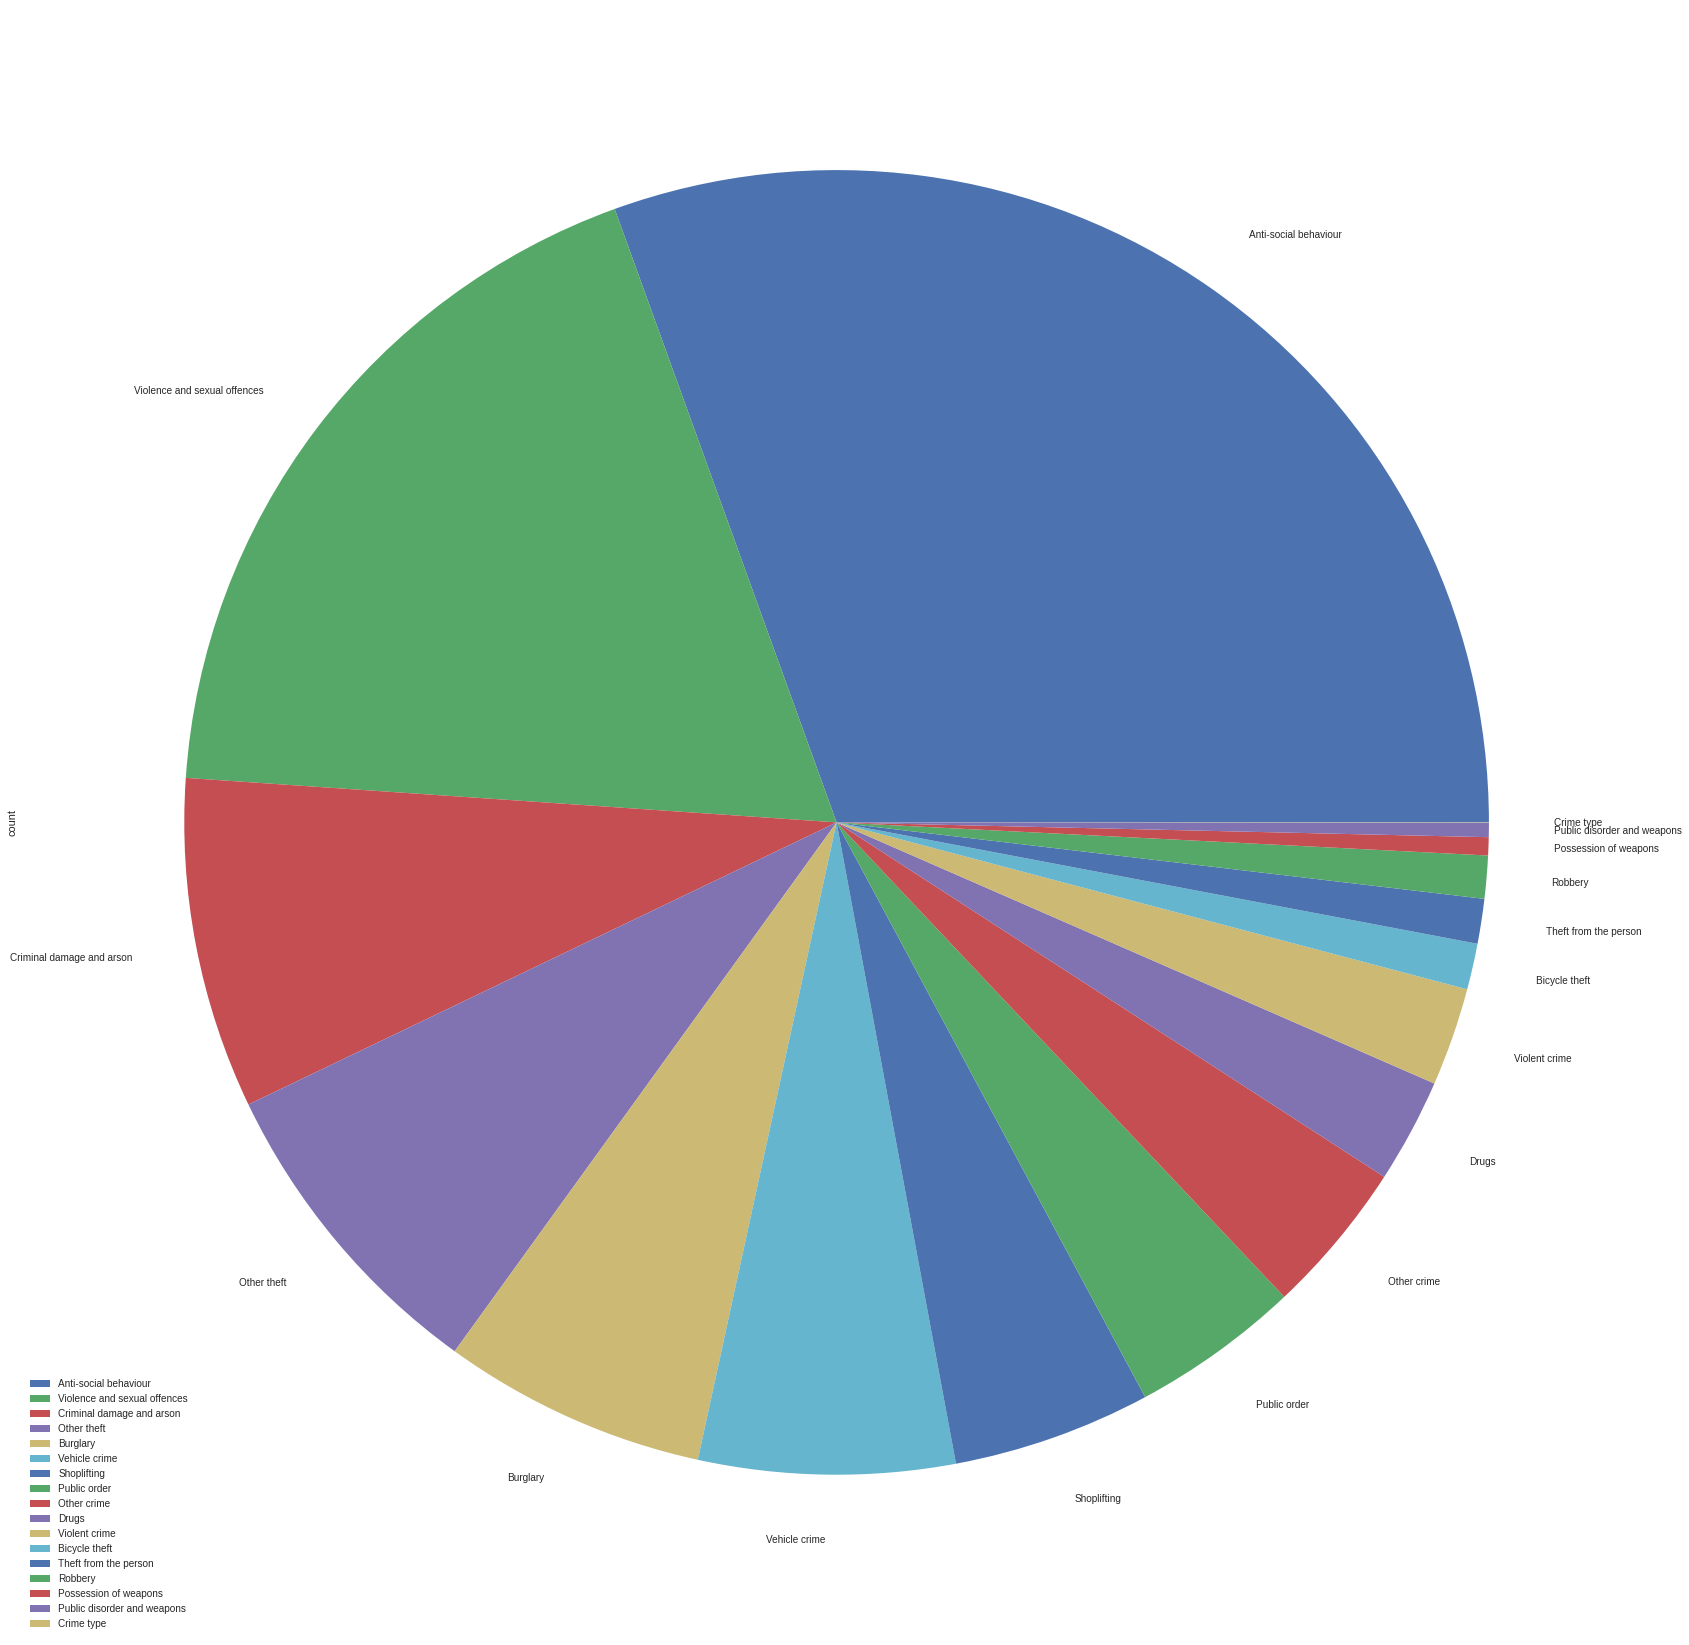

In [6]:
## Pie chart for Crime type

import matplotlib.pyplot as plt
pan_df = crime_type.toPandas()

with_index = (pan_df).set_index('Crime type')
plot = with_index.plot.pie(y='count', figsize=(200, 30))

In [7]:
# Top 5 most frequent crimes in UK
crimes_pd_df = crime_type.limit(5).toPandas()

display(crimes_pd_df)
merged_csv.count()  ## Total number of crimes

/usr/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:87: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 1.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)


Crime type     count
0         Anti-social behaviour  20962366
1  Violence and sexual offences  12627763
2     Criminal damage and arson   5635173
3                   Other theft   5443577
4                      Burglary   4492296

68673316

In [8]:
pan_df.info() ############## To check dataframe df obtained from importing csv
pan_df['Crime type'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Crime type  17 non-null     object
 1   count       17 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 400.0+ bytes


Anti-social behaviour           1
Drugs                           1
Public disorder and weapons     1
Possession of weapons           1
Robbery                         1
Theft from the person           1
Bicycle theft                   1
Violent crime                   1
Other crime                     1
Violence and sexual offences    1
Public order                    1
Shoplifting                     1
Vehicle crime                   1
Burglary                        1
Other theft                     1
Criminal damage and arson       1
Crime type                      1
Name: Crime type, dtype: int64

<AxesSubplot:xlabel='Crime type'>

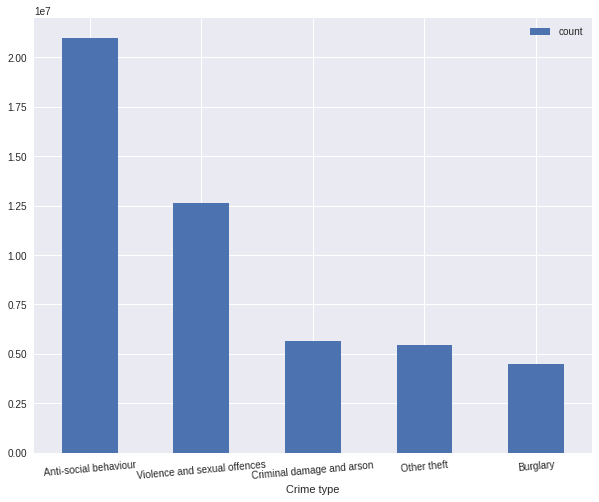

In [9]:
#pan_df.plot.hist(column=["Crime type"],  figsize=(10, 8))
crimes_pd_df.plot.bar(x='Crime type', y='count', rot=5, figsize=(10, 8))

In [10]:
## Grouping by constabulary the crime pertains to
police_station = merged_csv.groupBy('Falls within').count().orderBy('count', ascending=False)
display(police_station)

+--------------------+--------+
|        Falls within|   count|
+--------------------+--------+
|Metropolitan Poli...|11798267|
|West Yorkshire Po...| 3280666|
|Greater Mancheste...| 3034429|
|West Midlands Police| 2943907|
|Lancashire Consta...| 2160404|
|South Yorkshire P...| 2061652|
|         Kent Police| 2041293|
|Thames Valley Police| 2030803|
|Hampshire Constab...| 2027581|
|  Northumbria Police| 1979469|
|        Essex Police| 1973202|
|Avon and Somerset...| 1870790|
|   Merseyside Police| 1788564|
|       Sussex Police| 1680194|
|Police Service of...| 1658357|
|  South Wales Police| 1539744|
|Devon & Cornwall ...| 1498955|
|Nottinghamshire P...| 1365753|
|  West Mercia Police| 1352574|
|Derbyshire Consta...| 1160076|
+--------------------+--------+
only showing top 20 rows

In [11]:
crimes_district_df = police_station.toPandas()

display(crimes_district_df)

/usr/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:87: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 1.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)


Falls within     count
0          Metropolitan Police Service  11798267
1                West Yorkshire Police   3280666
2            Greater Manchester Police   3034429
3                 West Midlands Police   2943907
4              Lancashire Constabulary   2160404
5               South Yorkshire Police   2061652
6                          Kent Police   2041293
7                 Thames Valley Police   2030803
8               Hampshire Constabulary   2027581
9                   Northumbria Police   1979469
10                        Essex Police   1973202
11      Avon and Somerset Constabulary   1870790
12                   Merseyside Police   1788564
13                       Sussex Police   1680194
14  Police Service of Northern Ireland   1658357
15                  South Wales Police   1539744
16             Devon & Cornwall Police   1498955
17              Nottinghamshire Police   1365753
18                  West Mercia Police   1352574
19             Derbyshire Constabulary   1160076
20                Staffordshire Police   1144370
21          Hertfordshire Constabulary   1114492
22                   Humberside Police   1064652
23                       Surrey Police   1053169
24               Cheshire Constabulary   1050237
25                    Cleveland Police   1023210
26               Leicestershire Police   1018253
27             Northamptonshire Police    890806
28         Cambridgeshire Constabulary    869925
29                Norfolk Constabulary    821679
30                       Dorset Police    795046
31                 Durham Constabulary    791225
32              North Yorkshire Police    781733
33                  North Wales Police    734149
34                 Lincolnshire Police    719748
35                 Bedfordshire Police    717483
36                Suffolk Constabulary    708134
37                        Gwent Police    695793
38        Gloucestershire Constabulary    649215
39                    Wiltshire Police    631116
40                 Warwickshire Police    574550
41            British Transport Police    534137
42                Cumbria Constabulary    499236
43                  Dyfed-Powys Police    457667
44               City of London Police     80678
45                        Falls within      5933

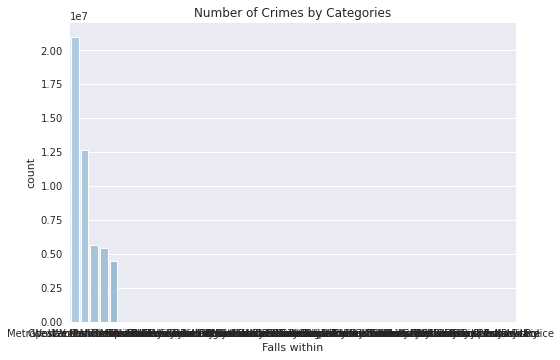

In [12]:
#location plot
fig, ax = plt.subplots()
import seaborn as sns
sns.set(rc={'figure.figsize':(30,20)})
sns.set_style("dark")
sns.barplot(x=crimes_district_df['Falls within'], y=crimes_pd_df['count'],palette="Blues_d",ax=ax)
ax.set_title("Number of Crimes by Categories")
display()

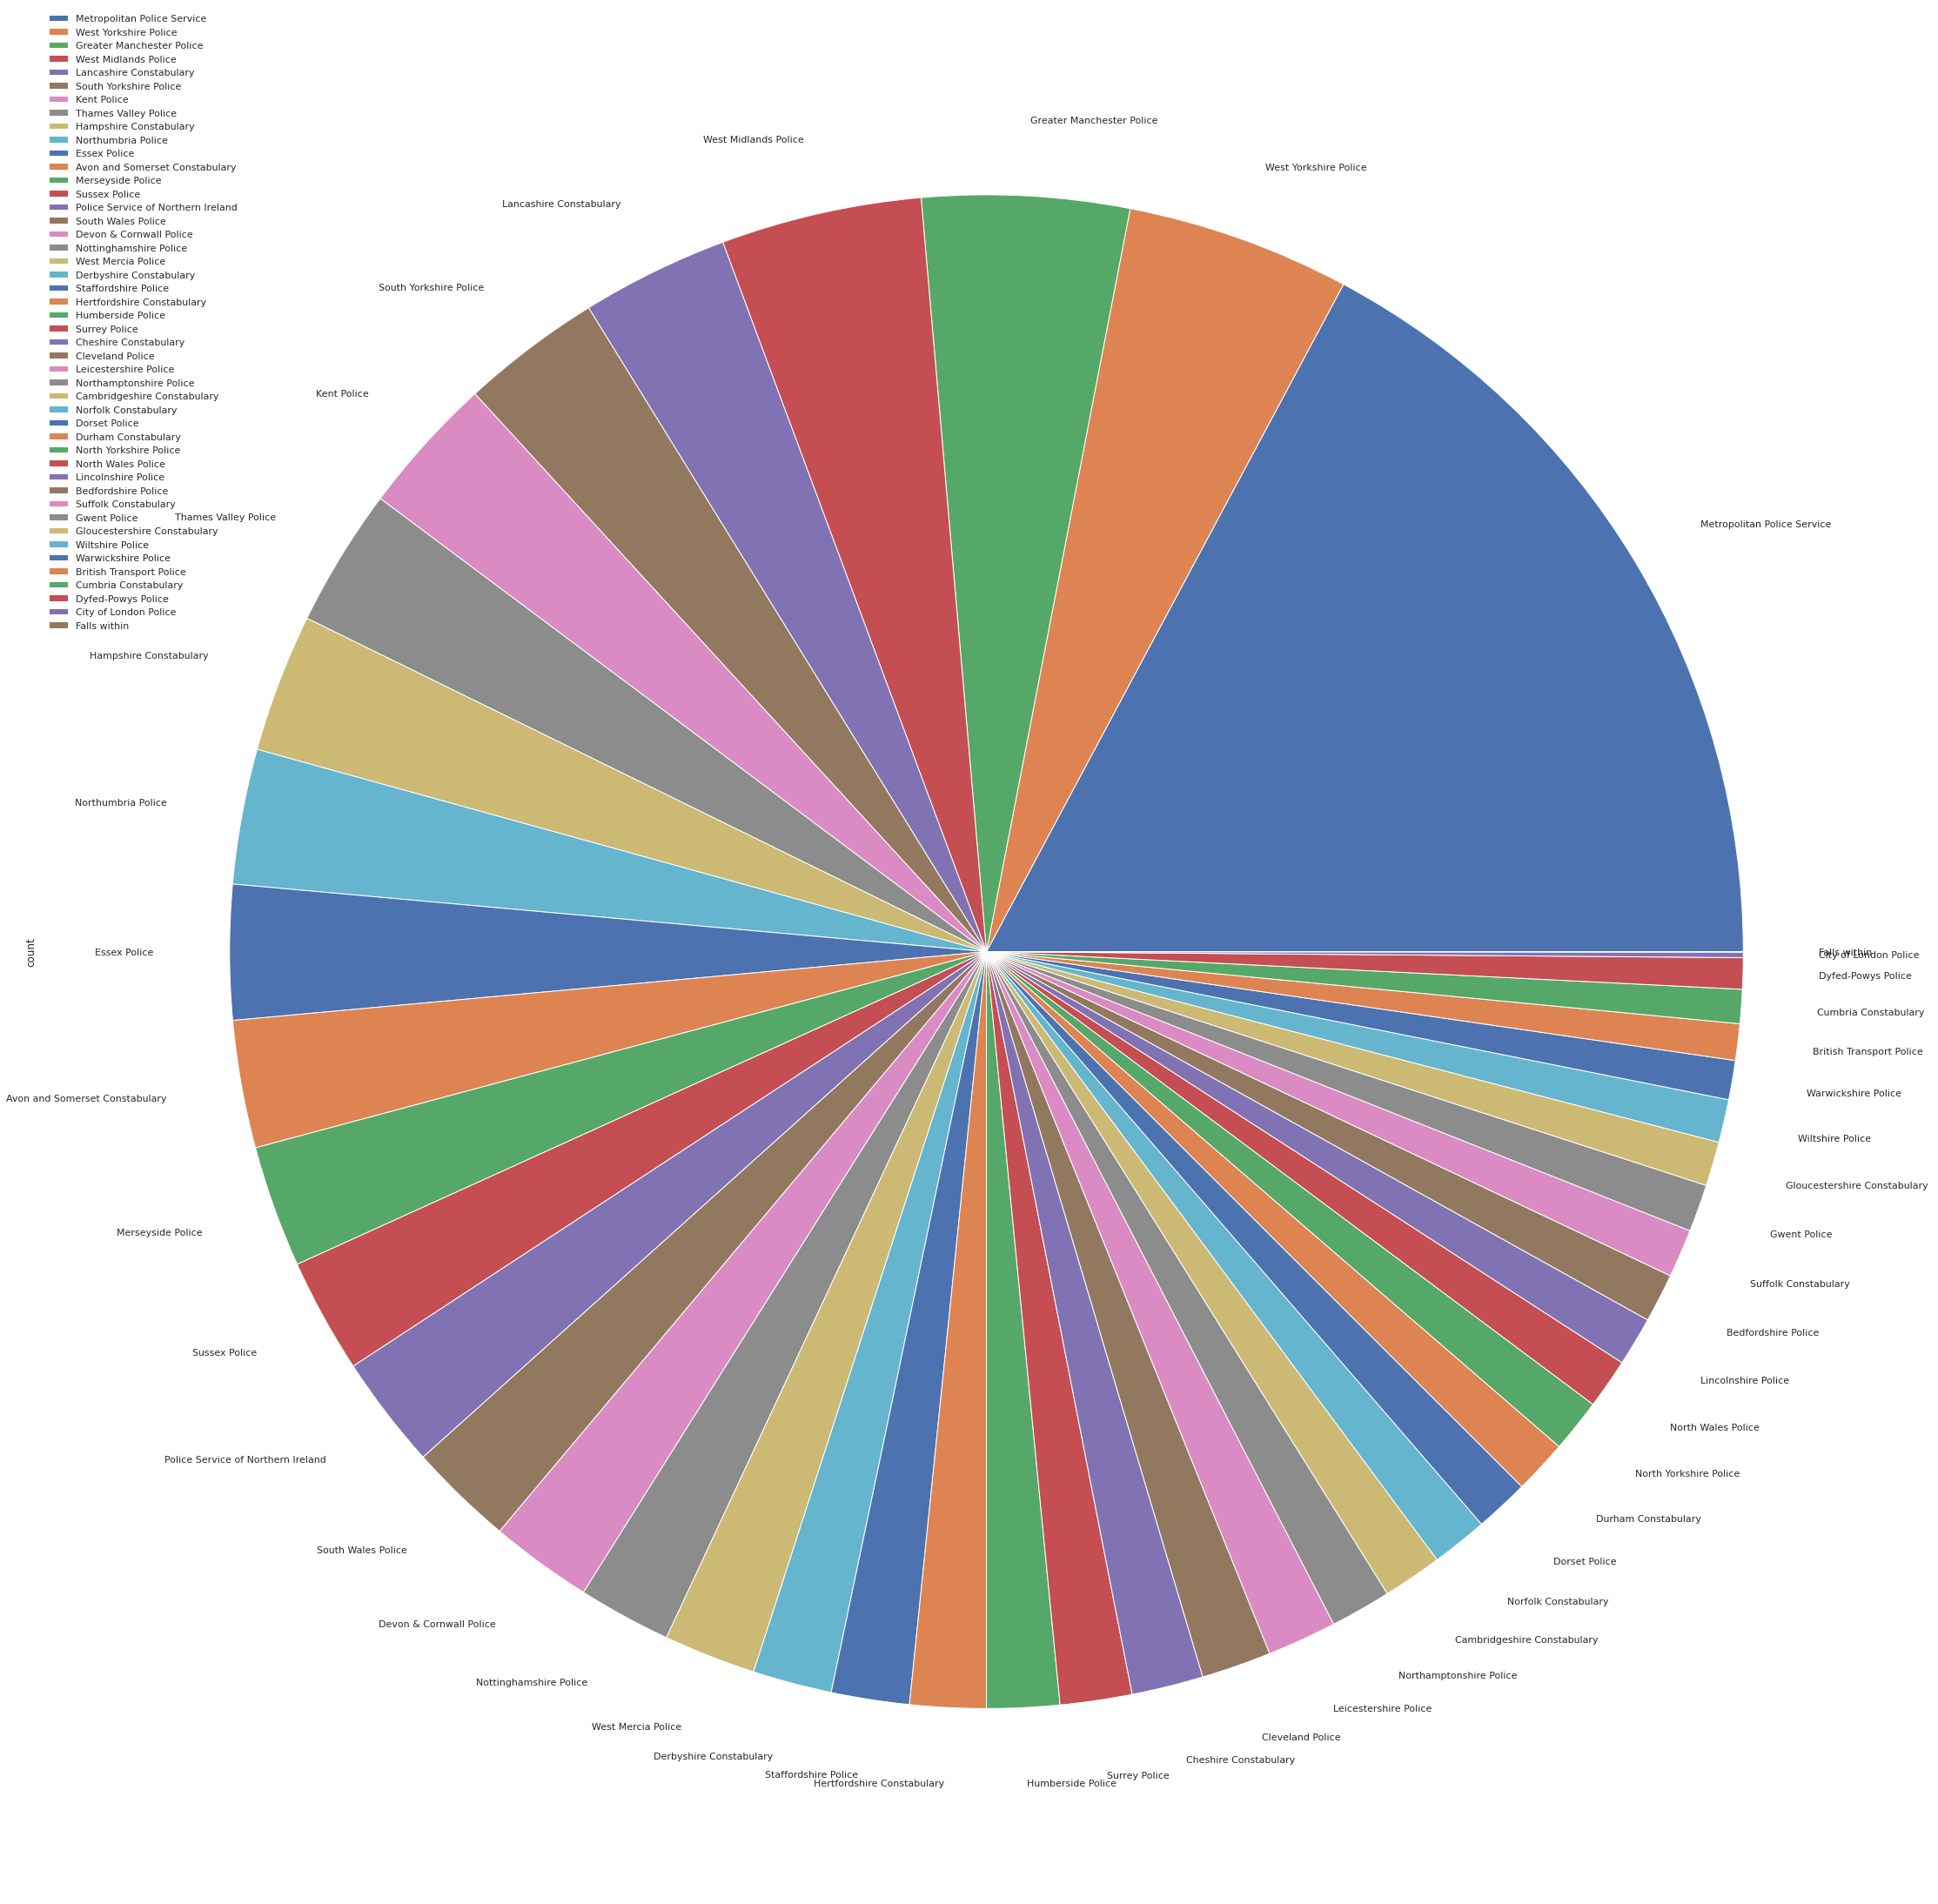

In [13]:
with_index = crimes_district_df.set_index('Falls within')
plot = with_index.plot.pie(y='count', figsize=(200, 40))

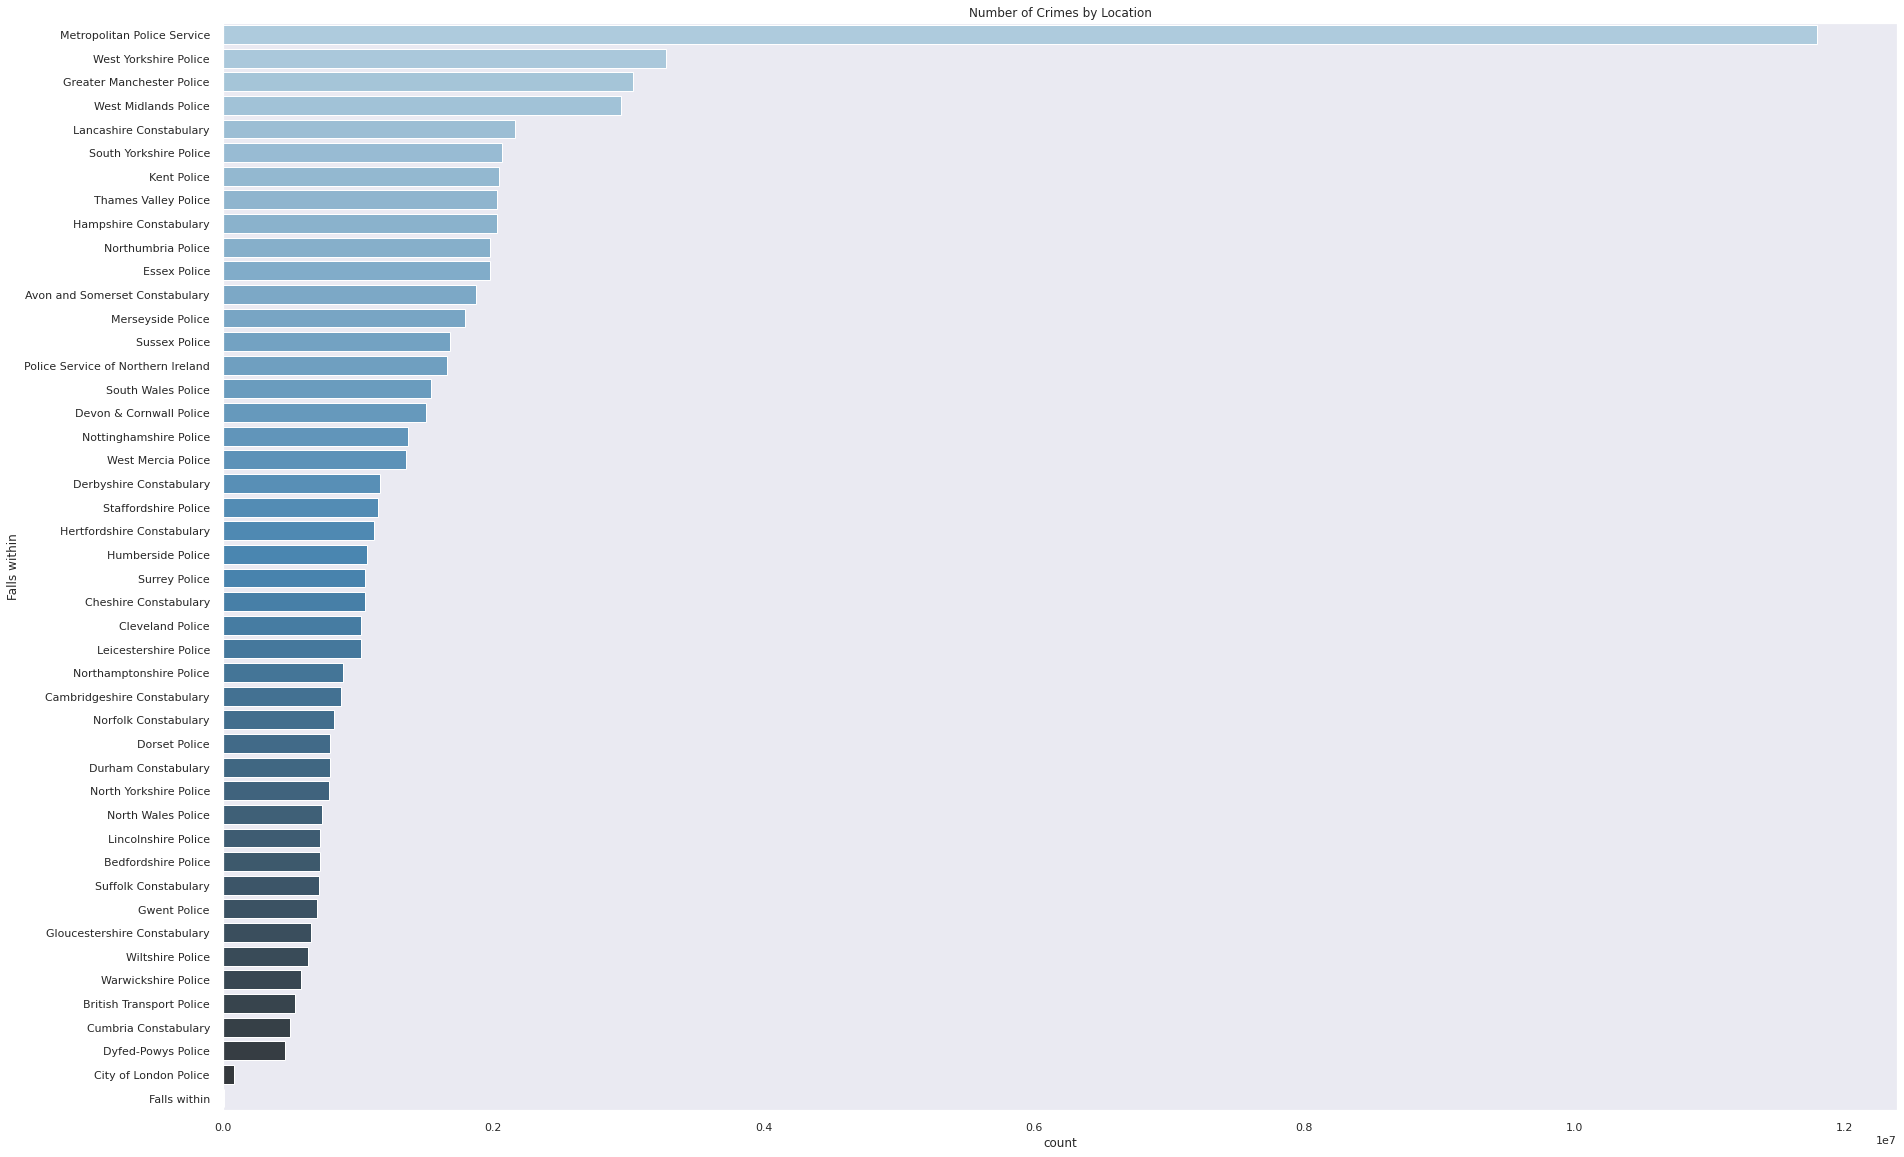

In [14]:
fig, ax = plt.subplots()
import seaborn as sns
sns.set(rc={'figure.figsize':(200,20)})
sns.set_style("dark")
sns.barplot(x=crimes_district_df['count'], y=crimes_district_df ['Falls within'],palette="Blues_d",ax=ax)  ## Can be replaced with locations
ax.set_title("Number of Crimes by Location")
display()

In [6]:
# For month
csv_df = everything.toDF('Crime ID', 'Month', 'Reported by', 'Falls within', 'Longitude', 'Latitude', 'Location', 'LSOA code', 'LSOA name', 'Crime type', 'Last outcome category', 'Context')
print(csv_df)


+--------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+-------+
|Crime ID|  Month|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code|           LSOA name|          Crime type|Last outcome category|Context|
+--------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+-------+
|    null|2010-12|Avon and Somerset...|Avon and Somerset...|-0.805600|51.819143|On or near Norfol...|E01017662| Aylesbury Vale 015C|         Other crime|                 null|   null|
|    null|2010-12|Avon and Somerset...|Avon and Somerset...|-2.494366|51.418169|On or near Keynsh...|E01014399|Bath and North Ea...|Anti-social behav...|                 null|   null|
|    null|2010-12|Avon and Somerset...|Avon and Somerset...|-2.511927|51.409435|

In [7]:
from datetime import datetime
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DateType
from pyspark.sql.functions import split

from pyspark.sql.functions import to_date, date_format
df_new=csv_df.withColumn('Month',to_date(csv_df.Month,"yyyy-MM"))

split_col = split(df_new['Month'], '-')

df_new = df_new.select('Crime ID',split_col.getItem(0).alias('Year'),split_col.getItem(1).alias('Month'), 'Reported by', 'Falls within', 'Longitude', 'Latitude', 'Location', 'LSOA code', 'LSOA name', 'Crime type', 'Last outcome category', 'Context')
   
df_new

+--------+----+-----+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+-------+
|Crime ID|Year|Month|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code|           LSOA name|          Crime type|Last outcome category|Context|
+--------+----+-----+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+-------+
|    null|2010|   12|Avon and Somerset...|Avon and Somerset...|-0.805600|51.819143|On or near Norfol...|E01017662| Aylesbury Vale 015C|         Other crime|                 null|   null|
|    null|2010|   12|Avon and Somerset...|Avon and Somerset...|-2.494366|51.418169|On or near Keynsh...|E01014399|Bath and North Ea...|Anti-social behav...|                 null|   null|
|    null|2010|   12|Avon and Somerset...|Avon and Somerset...|-2.511927|51.409435|On or near Harlec...|E01014399|Bath and North Ea...|Anti-social behav...|                 null|   null|
|    null|2010|   12|Avon and Somerset...|Avon and Somerset...|-2.511571|51.414895|On or near Orchar...|E01014399|Bath and North Ea...|Anti-social behav...|                 null|   null|
|    null|2010|   12|Avon and Somerset...|Avon and Somerset...|-2.511927|51.409435|On or near Harlec...|E01014399|Bath and North Ea...|Anti-social behav...|                 null|   null|
|    null|2010|   12|Avon and Somerset...|Avon and Somerset...|-2.511927|51.409435|On or near Harlec...|E01014399|Bath and North Ea...|Anti-social behav...|                 null|   null|
|    null|2010|   12|Avon and Somerset...|Avon and Somerset...|-2.513308|51.409456|On or near Charlt...|E01014399|Bath and North Ea...|            Burglary|                 null|   null|
|    null|2010|   12|Avon and Somerset...|Avon and Somerset...|-2.509126|51.416137|On or near St. Fr...|E01014399|Bath and North Ea...|            Burglary|                 null|   null|
|    null|2010|   12|Avon and Somerset...|Avon and Somerset...|-2.494366|51.418169|On or near Keynsh...|E01014399|Bath and North Ea...|         Other crime|                 null|   null|
|    null|2010|   12|Avon and Somerset...|Avon and Somerset...|-2.497767|51.420232|On or near Chando...|E01014400|Bath and North Ea...|Anti-social behav...|                 null|   null|
|    null|2010|   12|Avon and Somerset...|Avon and Somerset...|-2.497799|51.415233|On or near Back Lane|E01014400|Bath and North Ea...|Anti-social behav...|                 null|   null|
|    null|2010|   12|Avon and Somerset...|Avon and Somerset...|-2.498613|51.416002|On or near High S...|E01014400|Bath and North Ea...|Anti-social behav...|                 null|   null|
|    null|2010|   12|Avon and Somerset...|Avon and Somerset...|-2.501806|51.417391|On or near St. Jo...|E01014400|Bath and North Ea...|Anti-social behav...|                 null|   null|
|    null|2010|   12|Avon and Somerset...|Avon and Somerset...|-2.501806|51.417391|On or near St. Jo...|E01014400|Bath and North Ea...|Anti-social behav...|                 null|   null|
|    null|2010|   12|Avon and Somerset...|Avon and Somerset...|-2.497799|51.415233|On or near Back Lane|E01014400|Bath and North Ea...|Anti-social behav...|                 null|   null|
|    null|2010|   12|Avon and Somerset...|Avon and Somerset...|-2.497799|51.415233|On or near Back Lane|E01014400|Bath and North Ea...|            Burglary|                 null|   null|
|    null|2010|   12|Avon and Somerset...|Avon and Somerset...|-2.498613|51.416002|On or near High S...|E01014400|Bath and North Ea...|            Burglary|                 null|   null|
|    null|2010|   12|Avon and Somerset...|Avon and Somerset...|-2.498613|51.416002|On or near High S...|E01014400|Bath and North Ea...|            Burglary|                 null|   null|
|    null|2010|   12|Avon and Somerset...|Avon and Somerset...|-2.501713|

In [18]:
### number of crimes arranged by month and Year
reported_during = df_new.groupby('Month','Year').count().orderBy('Month')
reported_during

+-----+----+------+
|Month|Year| count|
+-----+----+------+
| null|null|  5933|
|   01|2019|532072|
|   01|2012|492488|
|   01|2020|516674|
|   01|2021|465486|
|   01|2014|425578|
|   01|2011|514641|
|   01|2015|425727|
|   01|2016|450925|
|   01|2017|488629|
|   01|2018|518071|
|   01|2013|472481|
|   02|2012|479116|
|   02|2013|431220|
|   02|2015|413123|
|   02|2011|514329|
|   02|2018|477089|
|   02|2016|441241|
|   02|2014|405568|
|   02|2019|510173|
+-----+----+------+
only showing top 20 rows

In [19]:
by_month = df_new.groupBy('Month').count().orderBy('Month')
#by_month
by_month_df = by_month.toPandas()
by_month_df

/usr/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:87: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 1.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)


Month    count
0   None     5933
1     01  5302772
2     02  5087737
3     03  5720255
4     04  5697874
5     05  5977575
6     06  5929273
7     07  6244165
8     08  6029172
9     09  5663583
10    10  5908827
11    11  5495451
12    12  5610699

pandas.core.frame.DataFrame

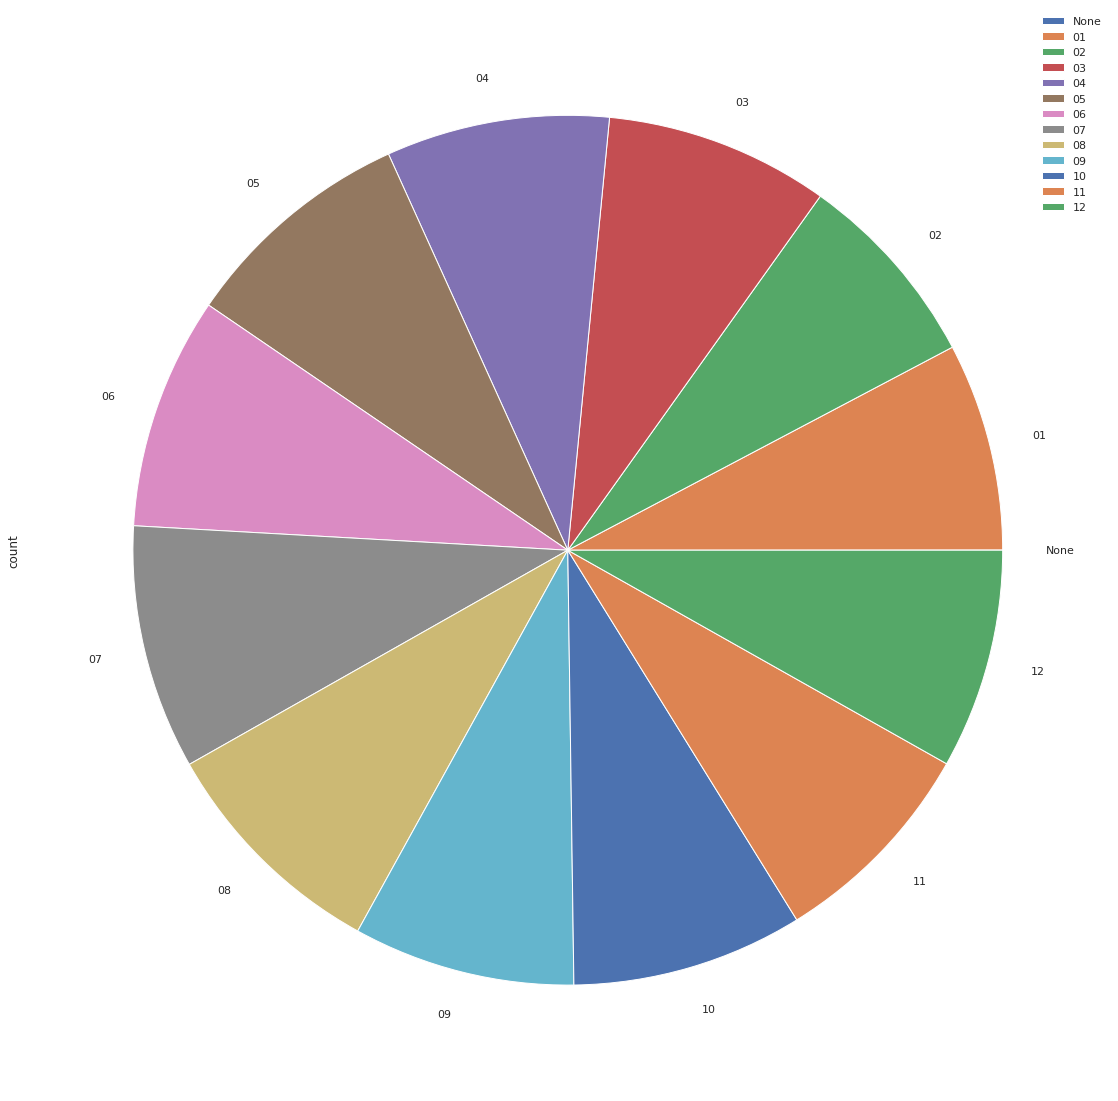

In [20]:



#Plot by month frequency
import pandas as pd
with_index = by_month_df.set_index('Month')
plot = with_index.plot.pie(y='count', figsize=(20, 20))

by_month_df = by_month_df.apply(pd.to_numeric) 
#pd.to_numeric(by_month_df)
type(by_month_df)


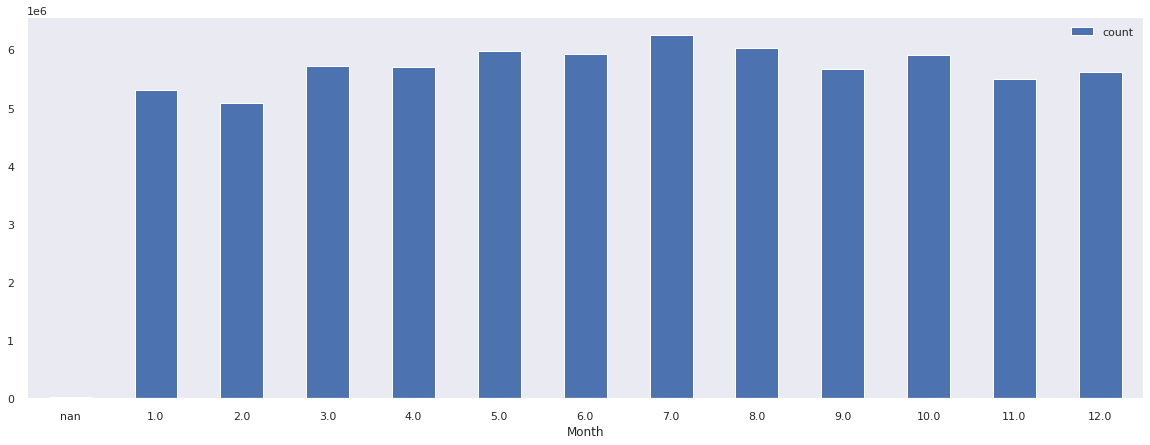

In [21]:
ax = by_month_df.plot.bar(x='Month', y='count', rot=0,  figsize=(20, 7))

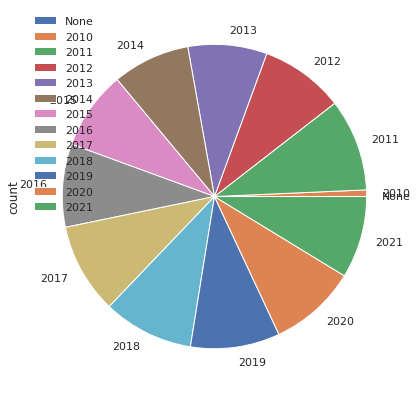

In [22]:
# For year

by_year = df_new.groupBy('Year').count().orderBy('Year')
#by_month
by_year_df = by_year.toPandas()
by_year_df

#Plot by month frequency
import pandas as pd
with_index = by_year_df.set_index('Year')
plot = with_index.plot.pie(y='count', figsize=(20, 7))

by_year_df = by_year_df.apply(pd.to_numeric) 

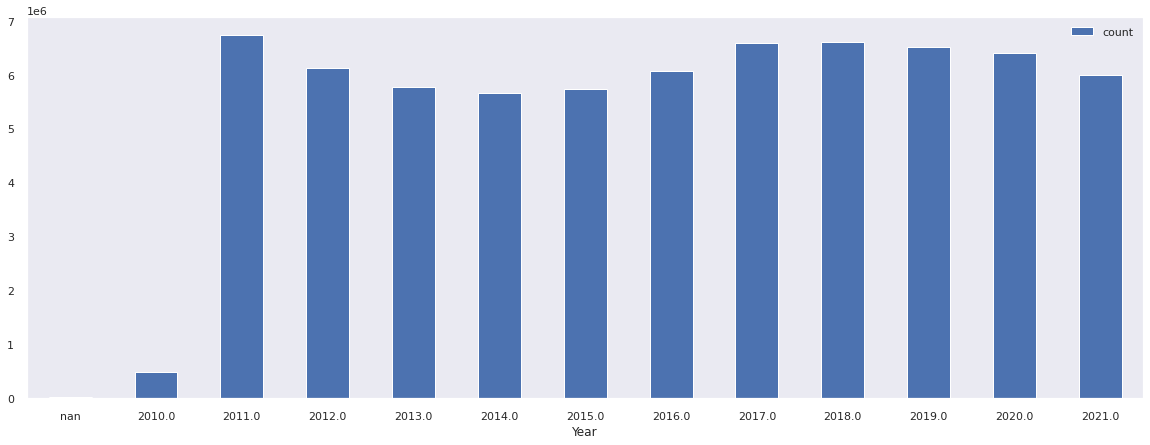

In [23]:
ax = by_year_df.plot.bar(x='Year', y='count', rot=0,  figsize=(20, 7))

In [24]:
month_year = df_new.groupby('Month','Year').count().orderBy('year','month')
display(month_year)

+-----+----+------+
|Month|Year| count|
+-----+----+------+
| null|null|  5933|
|   12|2010|474341|
|   01|2011|514641|
|   02|2011|514329|
|   03|2011|577983|
|   04|2011|606409|
|   05|2011|587662|
|   06|2011|578843|
|   07|2011|615552|
|   08|2011|599881|
|   09|2011|546061|
|   10|2011|578516|
|   11|2011|530471|
|   12|2011|479765|
|   01|2012|492488|
|   02|2012|479116|
|   03|2012|556780|
|   04|2012|489772|
|   05|2012|538104|
|   06|2012|512928|
+-----+----+------+
only showing top 20 rows

In [25]:
import pandas as pd
import numpy as np
import chart_studio.plotly as py
import cufflinks as cf
import seaborn as sns
import plotly.express as px
%matplotlib inline
import plotly.graph_objects as go

In [26]:
# outcome frequency

only_outcome= csv_df.groupBy('Last outcome category').count()
only_outcome


+---------------------+--------+
|Last outcome category|   count|
+---------------------+--------+
| Last outcome cate...|    5933|
|     Local resolution|  991145|
|       Offender fined|  242726|
| Offender ordered ...|   30567|
| Offender given su...|  170287|
| Offender given a ...|  899432|
| Court case unable...|  132812|
| Offender given co...|  185628|
| Offender given co...|  408042|
| Investigation com...|18703458|
| Offender otherwis...|   56571|
| Offender given ab...|    6869|
| Offender deprived...|   11235|
| Court result unav...| 1695795|
| Defendant sent to...|    4944|
| Offender given pe...|  215757|
| Suspect charged a...|  113678|
| Defendant found n...|  274294|
| Offender given a ...|  306480|
| Formal action is ...|  288802|
+---------------------+--------+
only showing top 20 rows

In [27]:
outcome_count_df = only_outcome.toPandas()

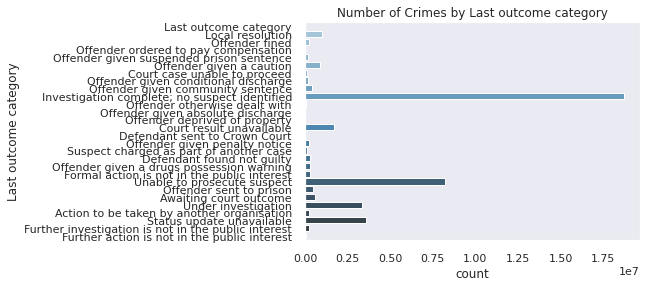

In [28]:
fig, ax = plt.subplots()
import seaborn as sns
sns.set(rc={'figure.figsize':(200,20)})
sns.set_style("dark")
sns.barplot(x=outcome_count_df['count'], y=outcome_count_df ['Last outcome category'],palette="Blues_d",ax=ax)  ## Can be replaced with locations
ax.set_title("Number of Crimes by Last outcome category")
display()

In [29]:
risky_locations = df_new.groupby('Location').count().orderBy('count',ascending = False)
risky_pandas = risky_locations.toPandas()

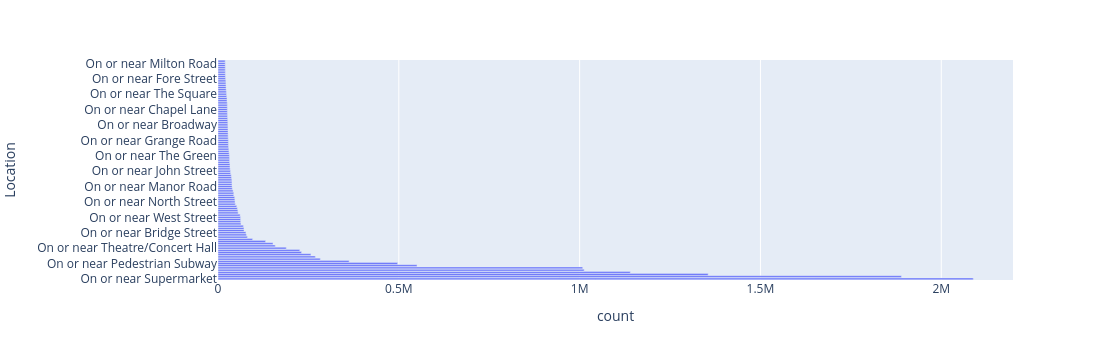

In [30]:
random_rows = risky_pandas.head(100)

import plotly.express as px
fig = px.bar(random_rows, x="count", y="Location", orientation='h')
fig.show()

In [39]:
## Location and crime taken together
location_crime = df_new.groupby('Location','Crime type').count().orderBy('count')
location_crime_pandas = location_crime.toPandas()

In [40]:
features = ['Month','Year','Crime type', 'Location', 'Last outcome category']  #Location we will do seperately it requires sampling

In [ ]:
import plotly.express as px
fig = px.bar(location_crime_pandas, x="count", y="Crime type", orientation='h')
fig.show()

In [42]:
# month and location
location_month = df_new.groupby('Location','Month').count().orderBy('count')
#location_month_pandas = location_month.toPandas()

#import plotly.express as px
#fig = px.bar(location_crime_pandas, x="count", y="Location", orientation='h')
#fig.show()

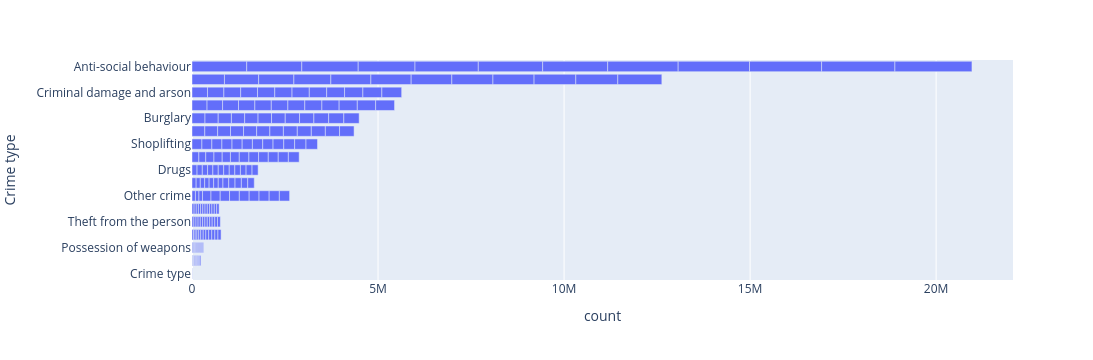

In [43]:
# month and Crime type
crime_month = df_new.groupby('Crime type','Month').count().orderBy('count')
crime_month_pandas =crime_month.toPandas()

import plotly.express as px
fig = px.bar(crime_month_pandas, x="count", y="Crime type", orientation='h')
fig.show()

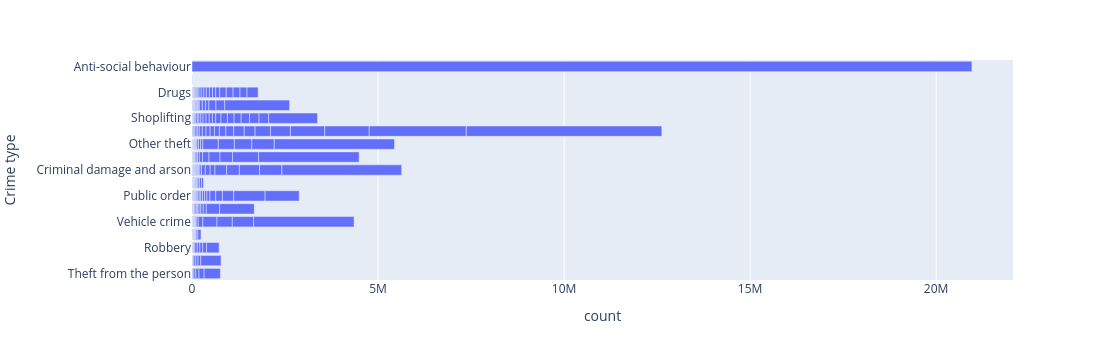

In [44]:
# month and outcome
crime_outcome = df_new.groupby('Crime type','Last outcome category').count().orderBy('count')
crime_outcome_pandas =crime_outcome.toPandas()

import plotly.express as px
fig = px.bar(crime_outcome_pandas, x="count", y="Crime type", orientation='h')
fig.show()

In [48]:
# location and outcome
location_outcome = df_new.groupby('Location','Last outcome category').count().orderBy('count')
location_outcome_pandas =location_outcome.toPandas()

In [ ]:
import plotly.express as px
fig = px.bar(location_outcome_pandas, x="count", y="Last outcome category", orientation='h')
fig.show()

In [49]:
# Crime type and outcome
crime_outcome = df_new.groupby('Crime type','Last outcome category').count().orderBy('count')
crime_outcome_pandas =location_outcome.toPandas()

import plotly.express as px
fig = px.bar(crime_outcome_pandas, x="count", y="Last outcome category", orientation='h')
fig.show()

ERROR:root:KeyboardInterrupt while sending command.               (2 + 20) / 22]
Traceback (most recent call last):
  File "/usr/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py", line 283, in _collect_as_arrow
    results = list(batch_stream)
  File "/usr/lib/python3.10/site-packages/pyspark/sql/pandas/serializers.py", line 53, in load_stream
    for batch in self.serializer.load_stream(stream):
  File "/usr/lib/python3.10/site-packages/pyspark/sql/pandas/serializers.py", line 91, in load_stream
    reader = pa.ipc.open_stream(stream)
  File "/usr/lib/python3.10/site-packages/pyarrow/ipc.py", line 154, in open_stream
    return RecordBatchStreamReader(source)
  File "/usr/lib/python3.10/site-packages/pyarrow/ipc.py", line 45, in __init__
    self._open(source)
  File "pyarrow/ipc.pxi", line 707, in pyarrow.lib._RecordBatchStreamReader._open
  File "pyarrow/error.pxi", line 143, in pyarrow.lib.pyarrow_internal_check_status
  File "/usr/lib/python3.10/socket.py", line 705, 

KeyboardInterrupt: 

In [9]:
df_features = df_new.select('Crime type', 'Location', 'Last outcome category')
df_features

+--------------------+--------------------+---------------------+
|          Crime type|            Location|Last outcome category|
+--------------------+--------------------+---------------------+
|         Other crime|On or near Norfol...|                 null|
|Anti-social behav...|On or near Keynsh...|                 null|
|Anti-social behav...|On or near Harlec...|                 null|
|Anti-social behav...|On or near Orchar...|                 null|
|Anti-social behav...|On or near Harlec...|                 null|
|Anti-social behav...|On or near Harlec...|                 null|
|            Burglary|On or near Charlt...|                 null|
|            Burglary|On or near St. Fr...|                 null|
|         Other crime|On or near Keynsh...|                 null|
|Anti-social behav...|On or near Chando...|                 null|
|Anti-social behav...|On or near Back Lane|                 null|
|Anti-social behav...|On or near High S...|                 null|
|Anti-social behav...|On or near St. Jo...|                 null|
|Anti-social behav...|On or near St. Jo...|                 null|
|Anti-social behav...|On or near Back Lane|                 null|
|            Burglary|On or near Back Lane|                 null|
|            Burglary|On or near High S...|                 null|
|            Burglary|On or near High S...|                 null|
|            Burglary|On or near West V...|                 null|
|       Vehicle crime|On or near Tresco...|                 null|
+--------------------+--------------------+---------------------+
only showing top 20 rows

In [ ]:
cols = df_features.columns


In [54]:
full_panda = df_features.toPandas()

In [ ]:
sns.countplot(full_panda['Crime type'])
plt.xlabel('Crime type')
plt.title('Crime and it\'s Frequency' )

In [61]:
from sklearn.preprocessing import LabelEncoder
#
# Instantiate LabelEncoder
full_panda = full_panda.dropna()

In [ ]:
le = LabelEncoder()
full_panda[cols] = full_panda[cols].apply(LabelEncoder().fit_transform)

In [62]:
## correlation matrix

import seaborn as sns
corr = full_panda.corr()

corr.style.background_gradient(cmap='coolwarm').set_precision(2)

#sns.heatmap(corr, 
 #           xticklabels=corr.columns.values,
  #          yticklabels=corr.columns.values)

/tmp/ipykernel_1238111/609451350.py:6: FutureWarning:

this method is deprecated in favour of `Styler.format(precision=..)`



In [67]:
## Trying to predict the last outcome

X = full_panda.iloc[:, 0:1].values
y = full_panda.iloc[:, 2].values

array([[ 6],
       [ 0],
       [ 0],
       ...,
       [14],
       [15],
       [15]])

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=0)

In [ ]:
# ## Feature Scaling


from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
 # Model Preparations

 ## Logistic Regression


#Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(multi_class="multinomial", solver="lbfgs",  max_iter=100 )

classifier.fit(X_train, y_train)

In [ ]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)


pd.crosstab(
    y_test, y_pred, rownames=["Actual Activity"], colnames=["Predicted Activity"]
 )

import seaborn as sea


sea.set(rc={"figure.figsize": (15, 15)})

sea.heatmap(
    data=confusion_matrix(y_test, y_pred),
    fmt=".0f",
    annot=True,
    xticklabels=np.unique(y_test),
    yticklabels=np.unique(y_test),
 )

In [ ]:
### Finding Accuracy of Logistic Regression Model

# Finding accuracy of the model
truePred = np.diag(cm).sum()
falsePred = np.sum(cm) - truePred
Accuracy = (truePred) / (truePred istic Regression Mo+ falsePred)
Accuracy = Accuracy * 100
acc = float("{0:.2f}".format(Accuracy))
print("Accuracy of Logistic Regression model : " + str(acc) + "%")

from sklearn.metrics import roc_curve, auc


def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.decision_function(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], "k--")
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver operating characteristic Area Under Curve")
    for i in range(n_classes):
        ax.plot(
            fpr[i],
            tpr[i],
            label="ROC curve (area = %0.2f) for label %i" % (roc_auc[i], i),
        )
    ax.legend(loc="best")
    ax.grid(alpha=0.4)
    sea.despine()
    plt.show()


plot_multiclass_roc(classifier, X_test, y_test, n_classes=19, figsize=(26, 10))

# Top variates analysis

In [11]:
df_new = df_features.toPandas()

In [12]:
#top 3 location
df_top3_loc = df_new.query("Location in ('On or near Supermarket', 'On or near Parking Area','On or near Shopping Area')")

In [13]:
df_top3_loc

Crime type                 Location  \
2148424                 Other crime   On or near Supermarket   
2148431               Violent crime   On or near Supermarket   
2148435                 Other crime   On or near Supermarket   
2148436                 Other crime   On or near Supermarket   
2148440                 Other crime   On or near Supermarket   
...                             ...                      ...   
68673245               Public order   On or near Supermarket   
68673251  Criminal damage and arson  On or near Parking Area   
68673258  Criminal damage and arson  On or near Parking Area   
68673263                Other theft  On or near Parking Area   
68673272  Criminal damage and arson  On or near Parking Area   

                                  Last outcome category  
2148424                                            None  
2148431                                            None  
2148435                                            None  
2148436                                            None  
2148440                                            None  
...                                                 ...  
68673245                            Under investigation  
68673251                            Under investigation  
68673258  Investigation complete; no suspect identified  
68673263  Investigation complete; no suspect identified  
68673272  Investigation complete; no suspect identified  

[5333758 rows x 3 columns]

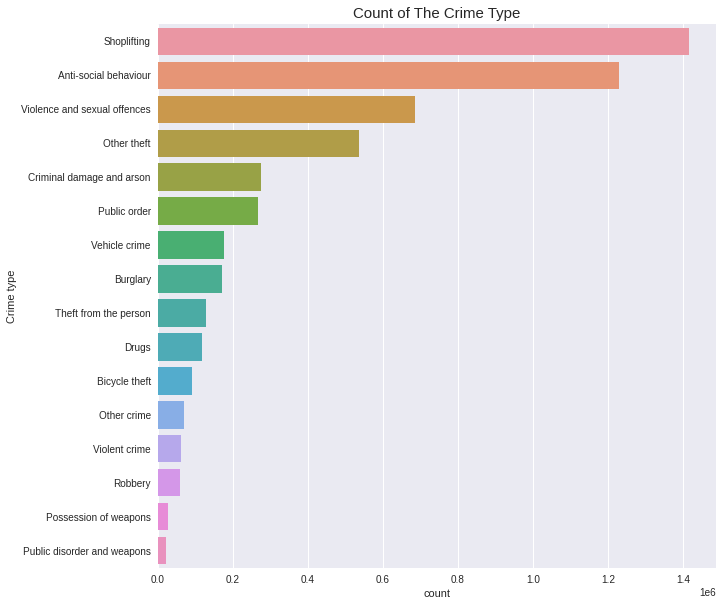

In [14]:
# What type of crimes often occur in the top 3 locations ?
plt.figure(figsize=(10,10))
sns.countplot(data=df_top3_loc, y='Crime type', order=df_top3_loc['Crime type'].value_counts().index)
plt.title('Count of The Crime Type', fontsize=15)
plt.show()

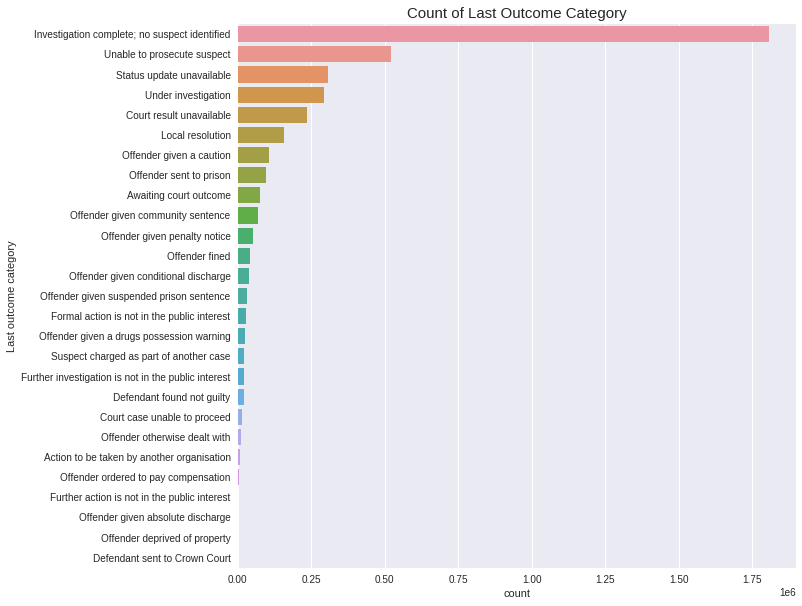

In [15]:
# What the last outcome that often appears in the top 3 locations ?
plt.figure(figsize=(10,10))
sns.countplot(data=df_top3_loc, y='Last outcome category', order=df_top3_loc['Last outcome category'].value_counts().index)
plt.title('Count of Last Outcome Category', fontsize=15)
plt.show()

## Analyze Top 3 Crime Type  

In [16]:
df_new = df_new.rename(columns={'Crime type':'CrimeType'})
df_top3_crime = df_new.query("CrimeType in ('Violence and sexual offences', 'Anti-social behaviour','Criminal damage and arson')")

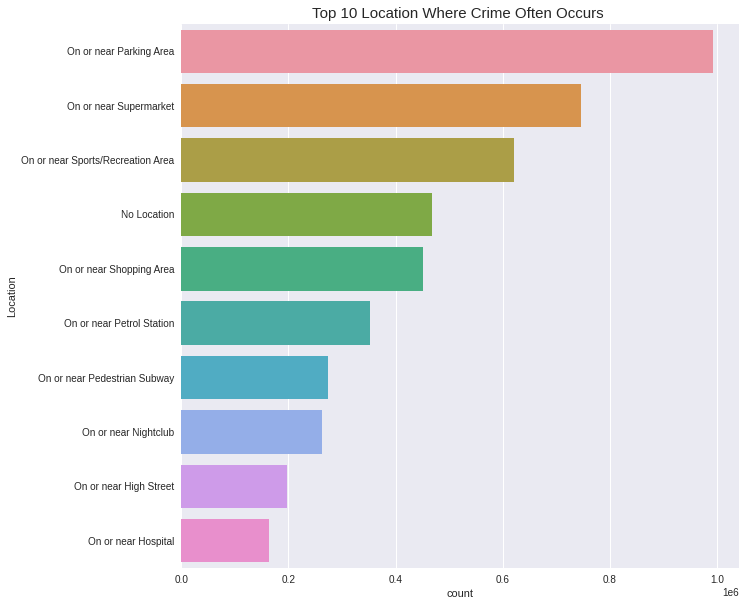

In [17]:
# Location where this type of crime often occurs
plt.figure(figsize=(10,10))
sns.countplot(data=df_top3_crime, y='Location', order=df_top3_crime['Location'].value_counts().index[:10])
plt.title('Top 10 Location Where Crime Often Occurs ', fontsize=15)
plt.show()

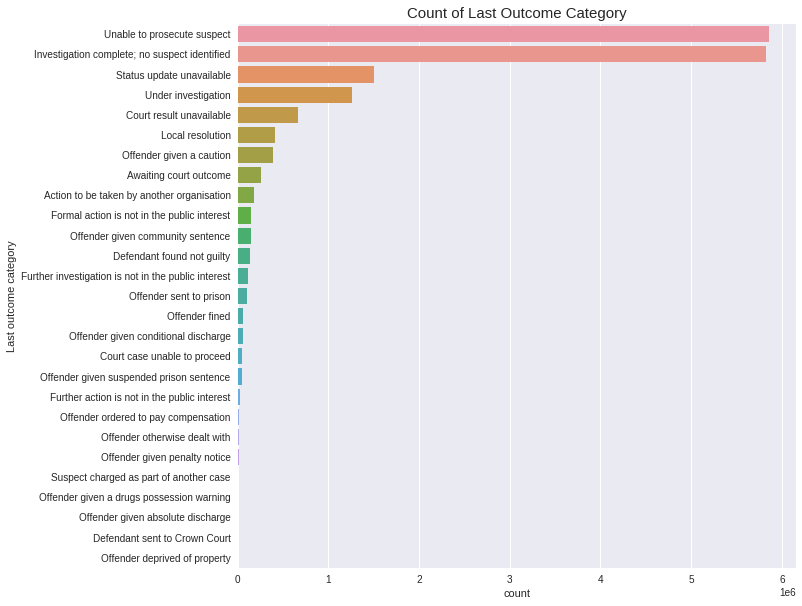

In [18]:
# What the last outcome that often appears in the top 3 crime type ?
plt.figure(figsize=(10,10))
sns.countplot(data=df_top3_crime, y='Last outcome category', order=df_top3_crime['Last outcome category'].value_counts().index)
plt.title('Count of Last Outcome Category', fontsize=15)
plt.show()

In [ ]:
# # Map where usually the top 1 crimes occur
# df_top3_crime_VO = df_top3_crime[df_top3_crime['CrimeType']=='Violence and sexual offences']
# fig = go.Figure(data=go.Scattergeo(
#         lon = df_top3_crime_VO['Longitude'],
#         lat = df_top3_crime_VO['Latitude'],
#         text = df_top3_loc_SM['Location'],
#         mode = 'markers',
#         ))

# fig.update_geos(
#     center=dict(lon=0, lat=51),
#     lataxis_range=[-50,50], lonaxis_range=[100, 200],
#     fitbounds="locations")

# fig.update_layout(
#         title = 'Map TOP 1 Crime',
#     )
# fig.show()

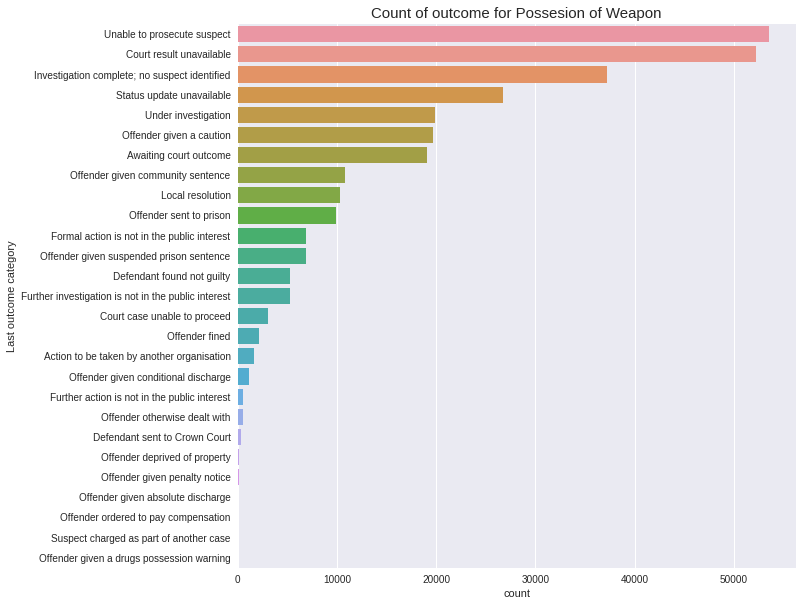

In [19]:
# What is the most outcome for possession of weapons
plt.figure(figsize=(10,10))
data1 = df_new[df_new['CrimeType']=='Possession of weapons']
sns.countplot(data=data1, y='Last outcome category', order=data1['Last outcome category'].value_counts().index)
plt.title('Count of outcome for Possesion of Weapon', fontsize=15)
plt.show()

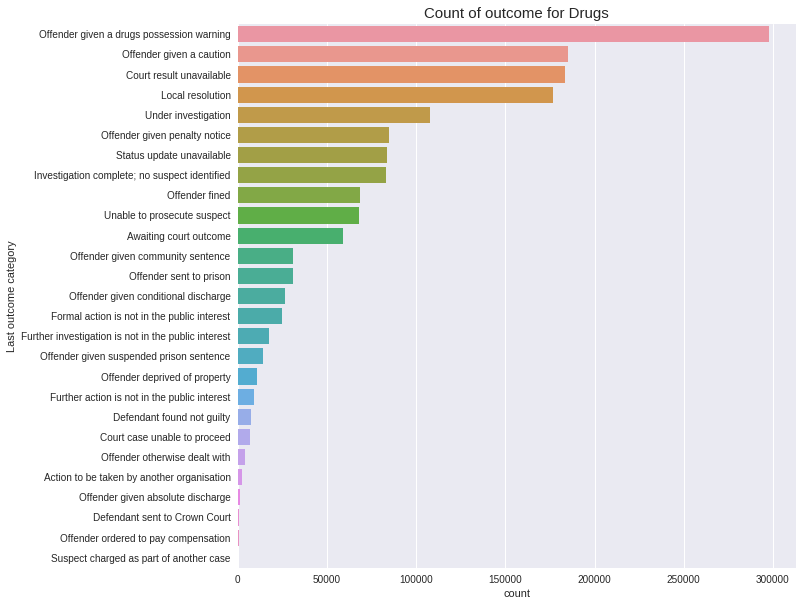

In [20]:
# What is the most outcome for drugs
plt.figure(figsize=(10,10))
data1 = df_new[df_new['CrimeType']=='Drugs']
sns.countplot(data=data1, y='Last outcome category', order=data1['Last outcome category'].value_counts().index)
plt.title('Count of outcome for Drugs', fontsize=15)
plt.show()

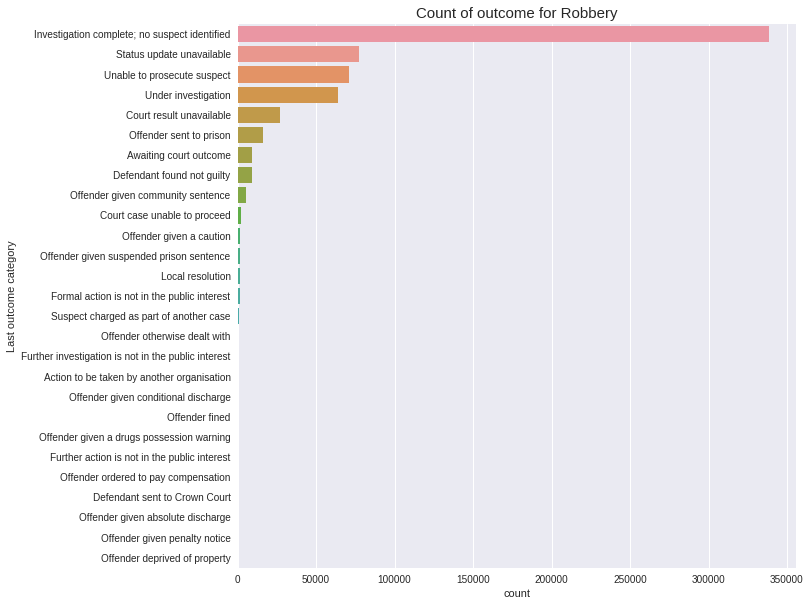

In [21]:
# What is the most outcome for robbery
plt.figure(figsize=(10,10))
data1 = df_new[df_new['CrimeType']=='Robbery']
sns.countplot(data=data1, y='Last outcome category', order=data1['Last outcome category'].value_counts().index)
plt.title('Count of outcome for Robbery', fontsize=15)
plt.show()

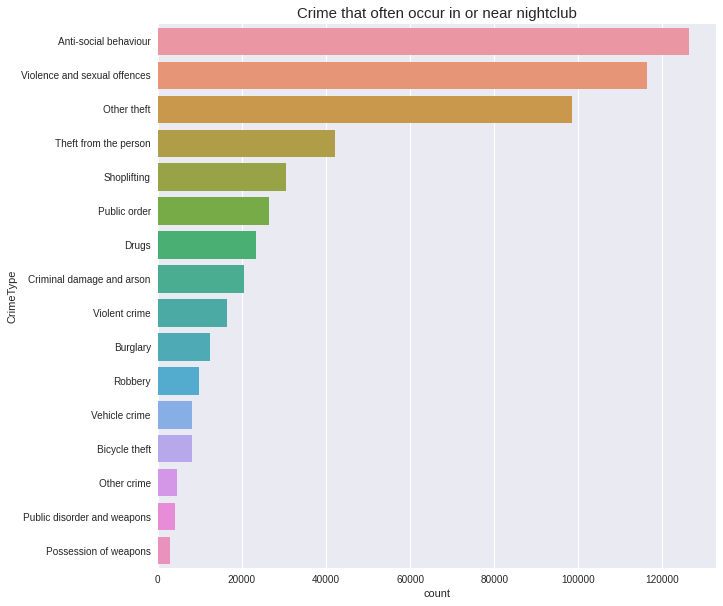

In [22]:
# Crime that often occur in or near nightclub
plt.figure(figsize=(10,10))
data1 = df_new[df_new['Location']=='On or near Nightclub']
sns.countplot(data=data1, y='CrimeType', order=data1['CrimeType'].value_counts().index)
plt.title('Crime that often occur in or near nightclub', fontsize=15)
plt.show()

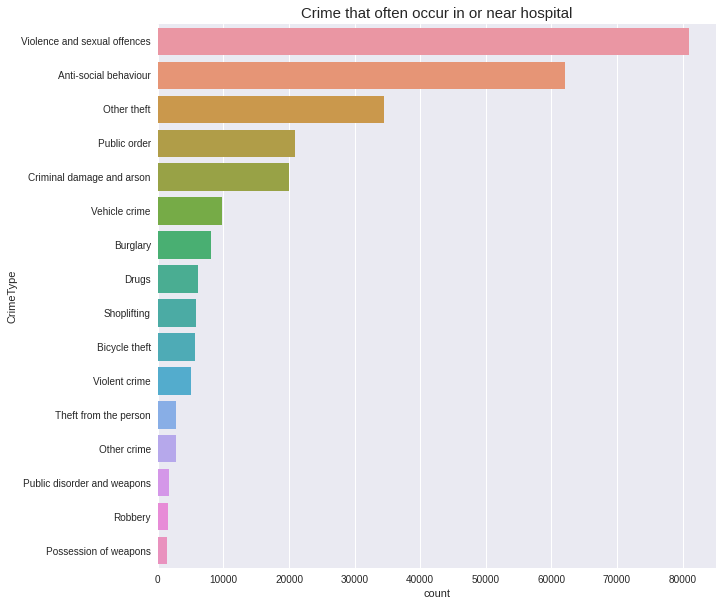

In [23]:
# Crime that often occur in or near hospital
plt.figure(figsize=(10,10))
data1 = df_new[df_new['Location']=='On or near Hospital']
sns.countplot(data=data1, y='CrimeType', order=data1['CrimeType'].value_counts().index)
plt.title('Crime that often occur in or near hospital', fontsize=15)
plt.show()

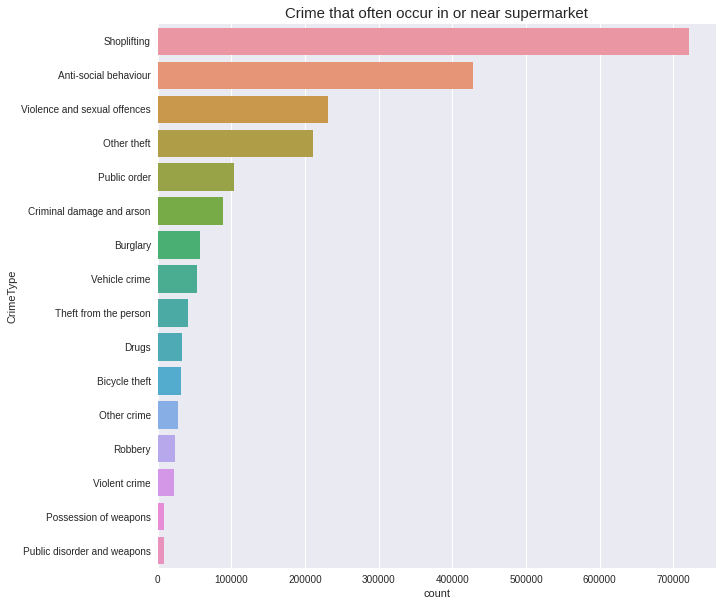

In [24]:
# Crime that often occur in or near supermarket
plt.figure(figsize=(10,10))
data1 = df_new[df_new['Location']=='On or near Supermarket']
sns.countplot(data=data1, y='CrimeType', order=data1['CrimeType'].value_counts().index)
plt.title('Crime that often occur in or near supermarket', fontsize=15)
plt.show()

# most common crimes at the most common locations.



In [27]:
def location_crime(df,search_field, search_term, Y):

    subset = df[df[search_field].str.contains(search_term)]

    plt.figure(figsize=(9,9))
    sns.countplot(data=subset, y=Y,
    order=subset[Y].value_counts().index[:100])
    Title = 'Crimes Most Committed at ' + search_term
    plt.title(Title, fontsize=15)
    plt.show()
    
df_new.Location.value_counts()

On or near Supermarket       2088481
On or near Parking Area      1889876
On or near Shopping Area     1355401
On or near Petrol Station    1140118
No Location                  1012424
                              ...   
On or near Bodorgan                1
On or near Maize Lane              1
On or near Wybridge                1
On or near Taylors Meade           1
On or near Cockford Bank           1
Name: Location, Length: 289206, dtype: int64

In [31]:
df_new

CrimeType                    Location  \
0                          Other crime  On or near Norfolk Terrace   
1                Anti-social behaviour    On or near Keynsham Road   
2                Anti-social behaviour    On or near Harlech Close   
3                Anti-social behaviour    On or near Orchard Close   
4                Anti-social behaviour    On or near Harlech Close   
...                                ...                         ...   
68673311                   Shoplifting   On or near Petrol Station   
68673312                 Vehicle crime     On or near Church Hatch   
68673313                 Vehicle crime    On or near Hamilton Park   
68673314  Violence and sexual offences    On or near The Headlands   
68673315  Violence and sexual offences    On or near The Headlands   

                                  Last outcome category  
0                                                  None  
1                                                  None  
2                                                  None  
3                                                  None  
4                                                  None  
...                                                 ...  
68673311                            Under investigation  
68673312  Investigation complete; no suspect identified  
68673313  Investigation complete; no suspect identified  
68673314                            Under investigation  
68673315                            Under investigation  

[68673316 rows x 3 columns]

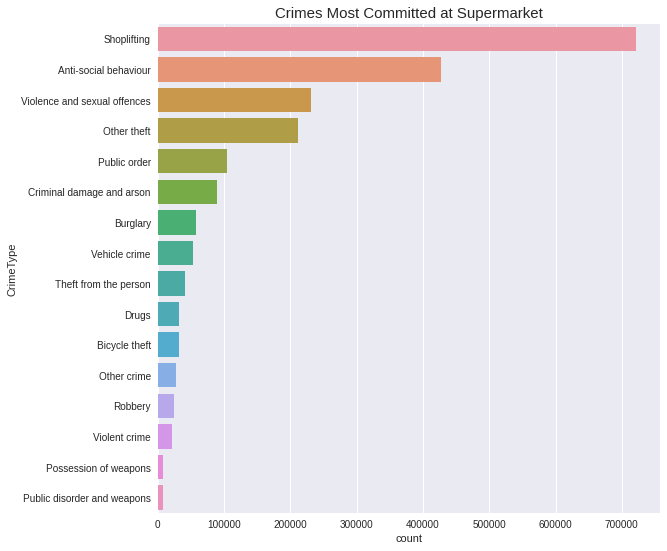

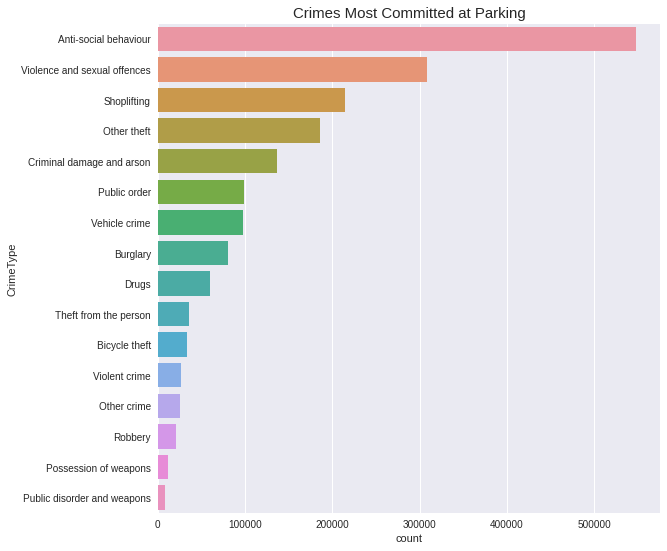

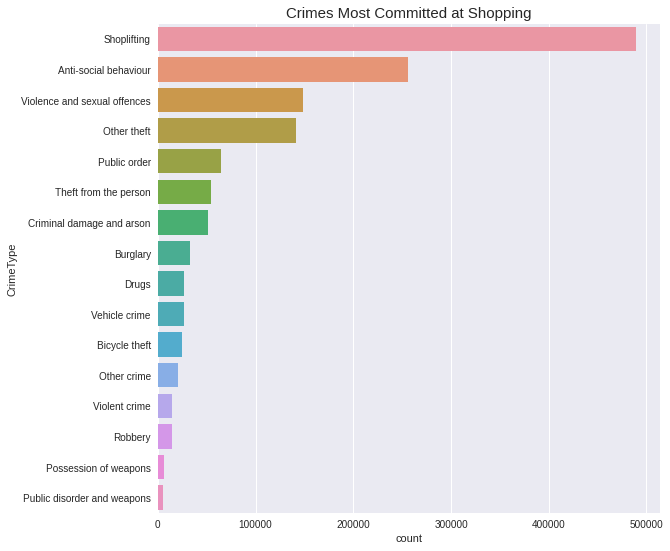

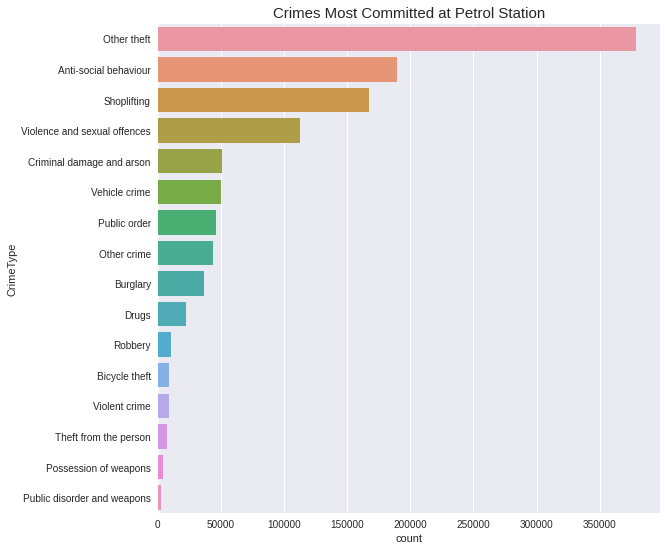

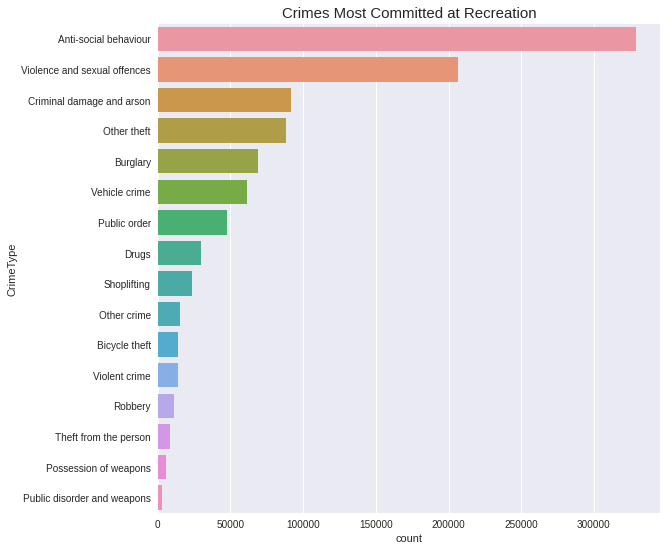

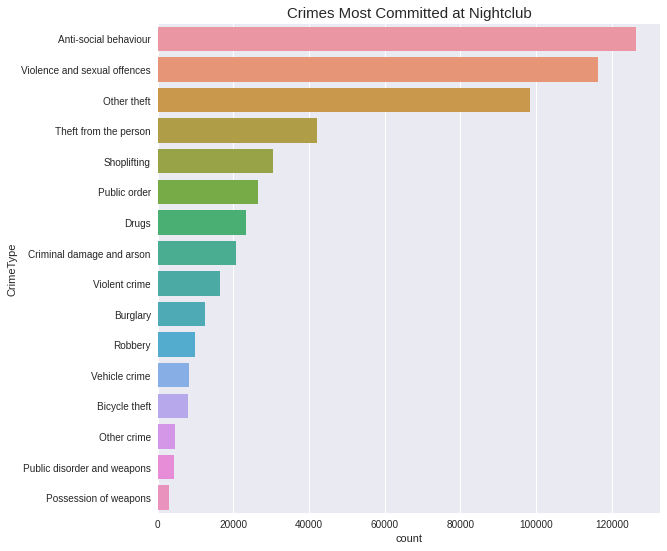

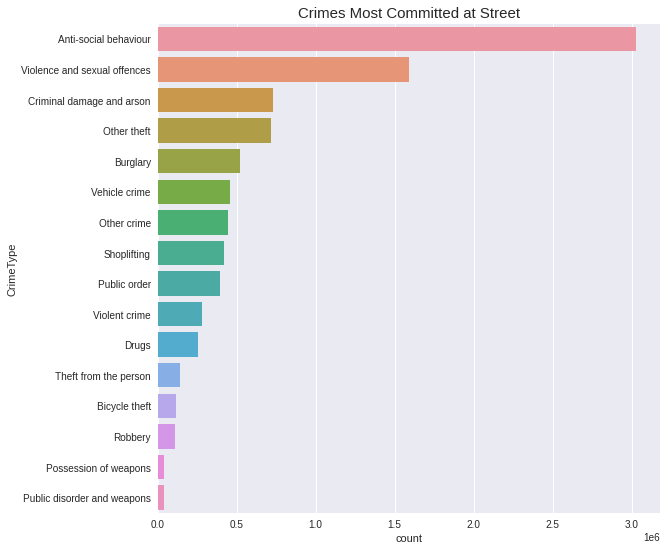

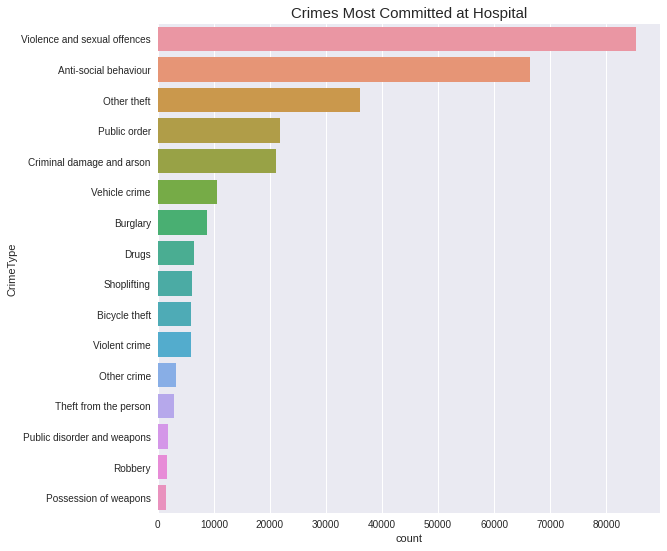

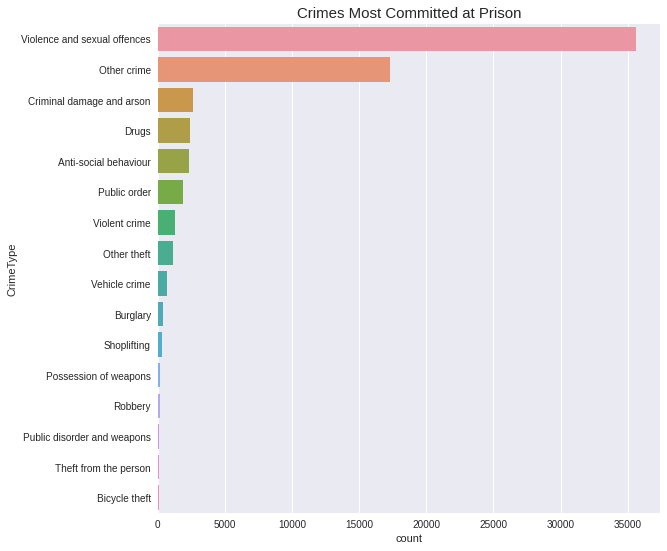

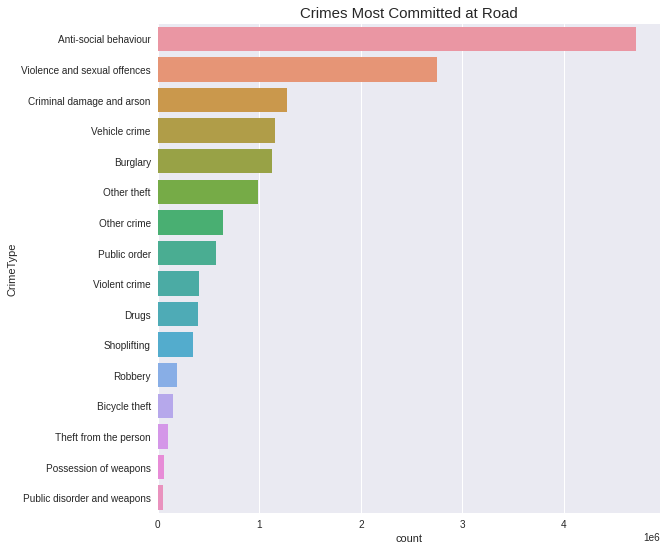

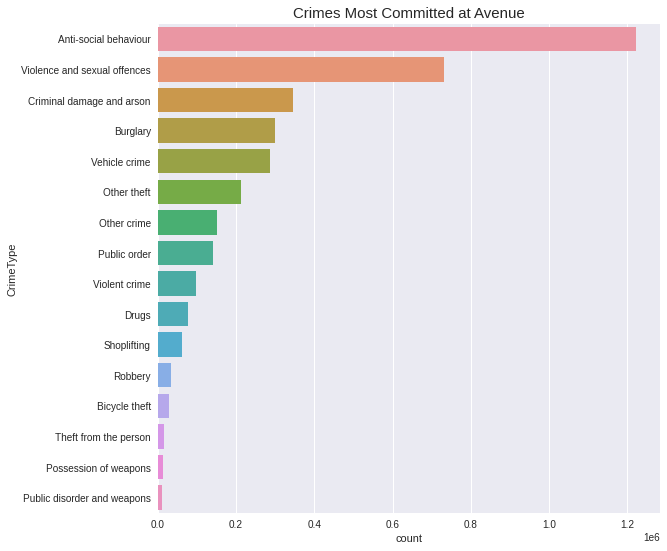

In [32]:
search_terms = ['Supermarket', 'Parking', 'Shopping', 'Petrol Station', 'Recreation', 'Nightclub', 'Street', 'Hospital', 'Prison', 'Road', 'Avenue']

for search_term in search_terms:
    location_crime(df_new,'Location', search_term, 'CrimeType')

# most common locations for certain crimes

In [35]:

def crime_location(df, search_field, search_term, Y):

    subset = df[df[search_field].str.contains(search_term)]
    plt.figure(figsize=(9,9))
    
    sns.countplot(data=subset, y=Y, order=subset[Y].value_counts().index[:20])
    Title = 'Top Locations of ' + search_term + ' Crimes'
    plt.title(Title, fontsize=15)
    plt.show()


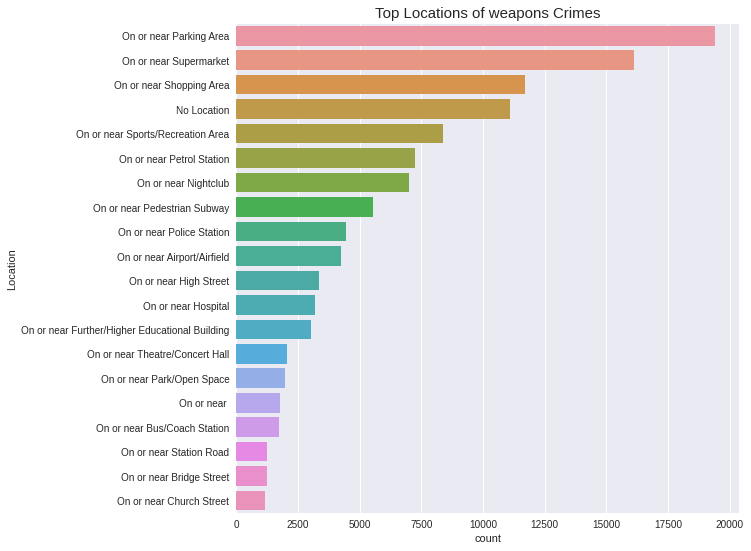

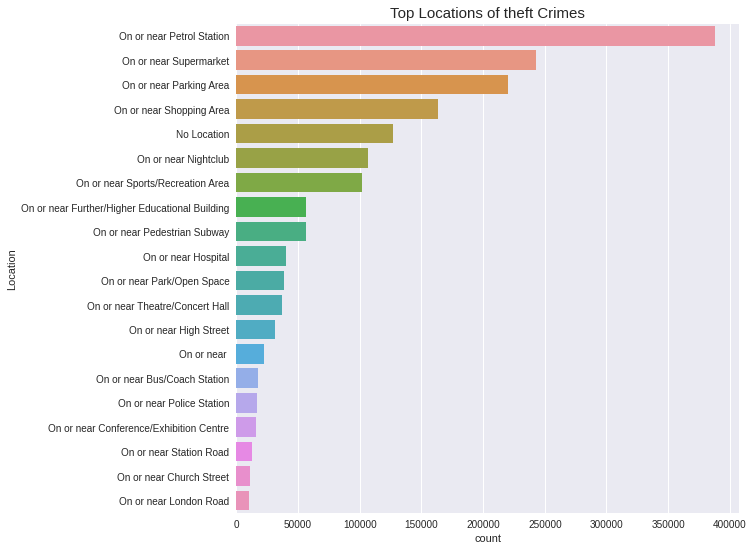

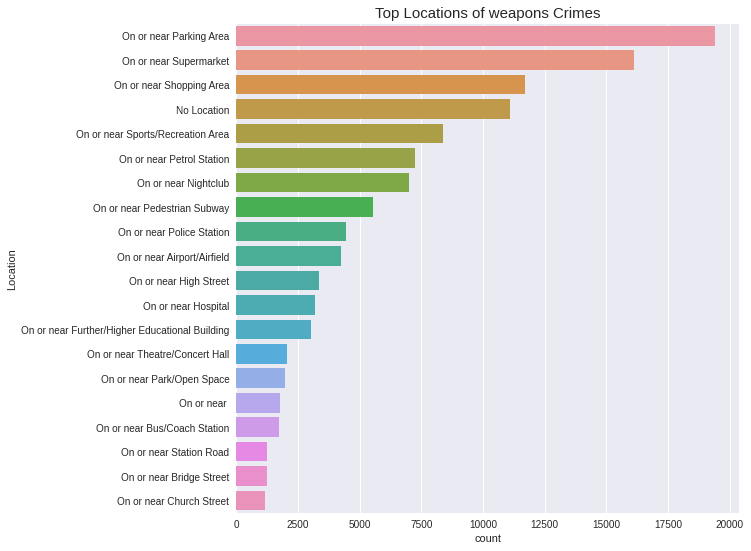

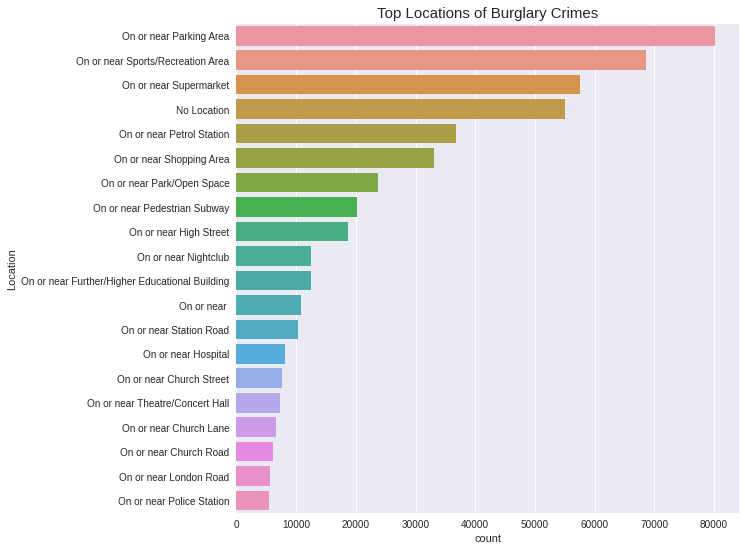

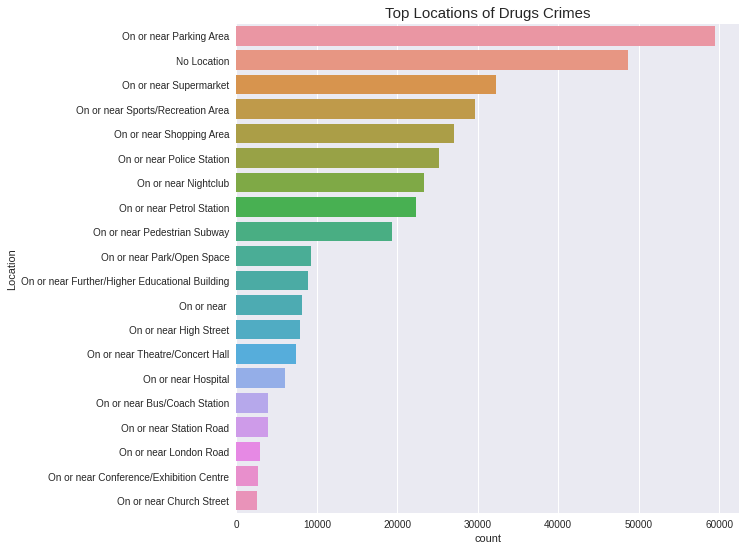

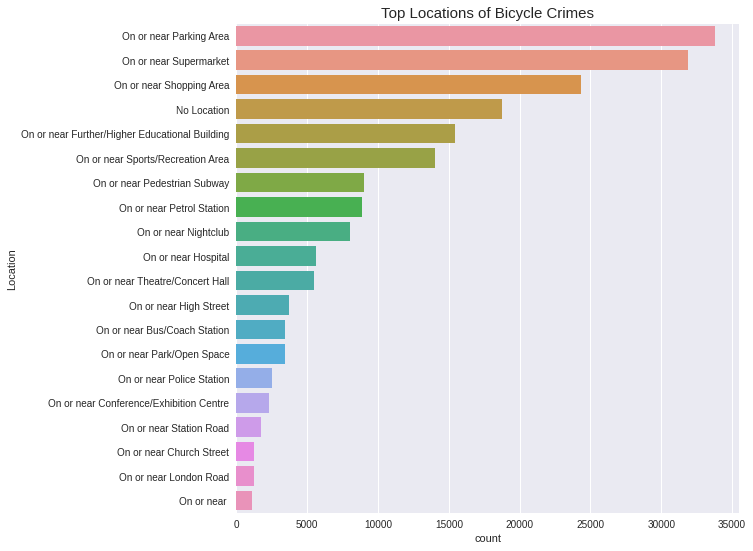

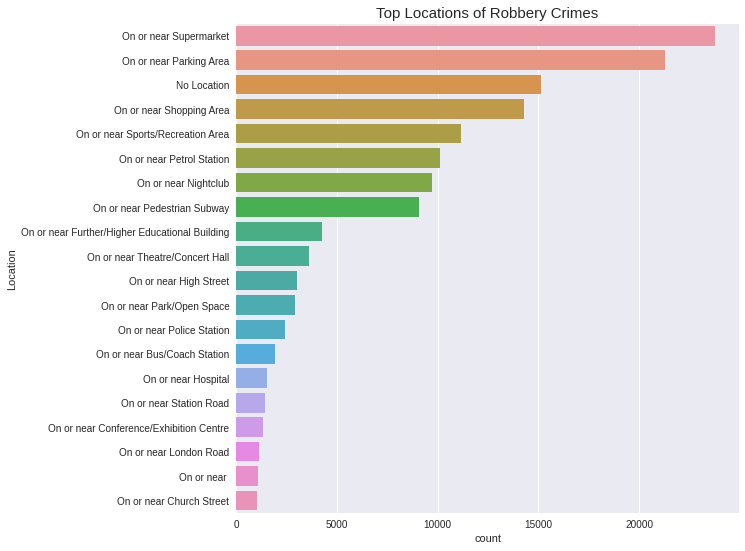

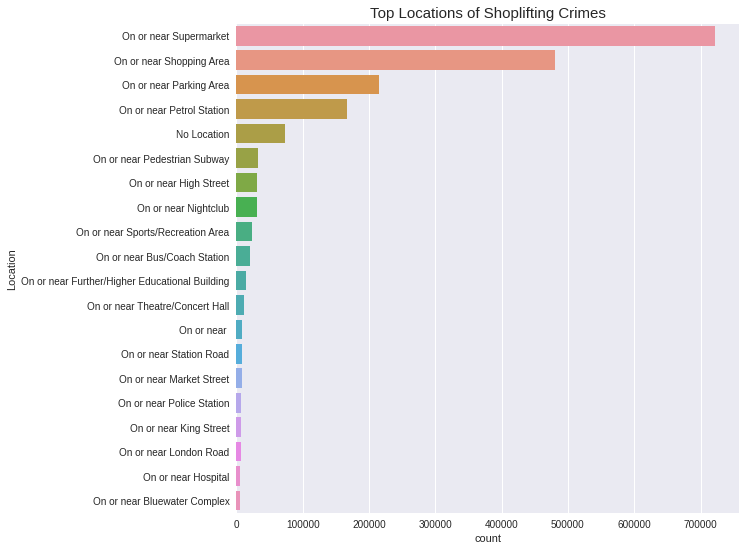

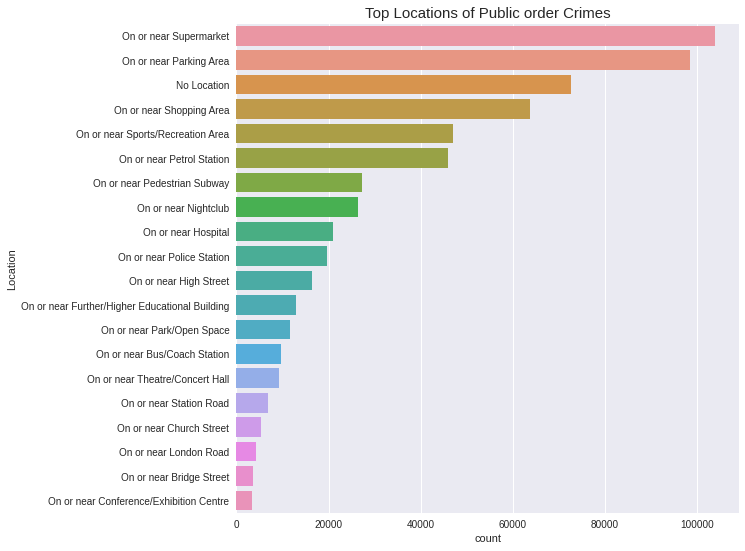

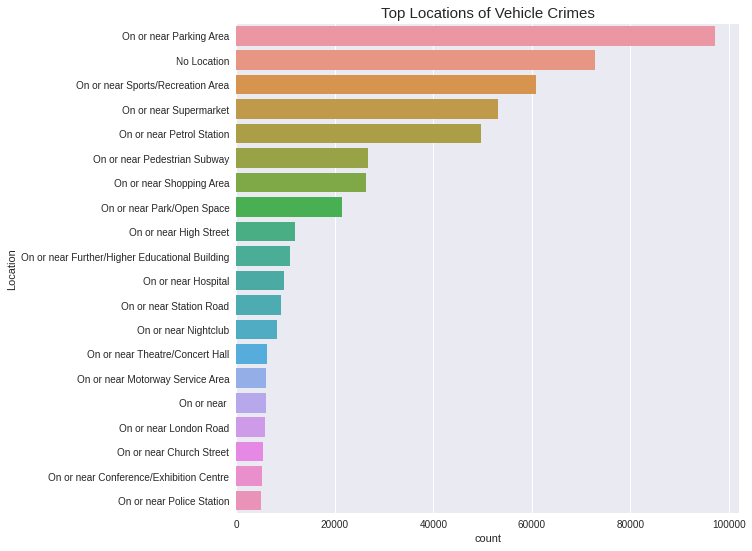

In [41]:
search_terms = ['theft', 'weapons', 'Burglary', 'Drugs', 'Bicycle','Robbery','Shoplifting', 'Public order','Vehicle']


crime_location(df_new, 'CrimeType','weapons', 'Location')

for search_term in search_terms:
    crime_location(df_new, 'CrimeType', search_term, 'Location')
    